# Modeling ALS Progression

In [129]:
import pandas as pd
import numpy as np
from keras.layers import (
    MultiHeadAttention,
    Dense,
    Dropout,
    LayerNormalization,
    Input,
    GlobalAveragePooling1D,
)
from keras.models import Model
from keras.optimizers.legacy import RMSprop
from sklearn.model_selection import KFold
from keras.callbacks import Callback, ModelCheckpoint
import os
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    r2_score,
)
import json
import warnings
import matplotlib.pyplot as plt
import seaborn as sbn

plt.rcParams["font.family"] = "IBM Plex Mono"

warnings.filterwarnings("ignore", category=Warning)

In [130]:
df = pd.read_csv('Data/preprocessed/data.csv')
df

subject_id    feature  0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  ...  \
0            1492  Q1_Speech  4.0  4.0  4.0  4.0  4.0  4.0  3.0  4.0  ...   
1            1524  Q1_Speech  4.0  3.0  4.0  4.0  4.0  4.0  3.0  4.0  ...   
2            2018  Q1_Speech  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  ...   
3            2025  Q1_Speech  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  ...   
4            2194  Q1_Speech  4.0  4.0  4.0  4.0  4.0  4.0  4.0  4.0  ...   
...           ...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
38935      996984   Riluzole  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
38936      997561   Riluzole  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
38937      997649   Riluzole  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
38938      998278   Riluzole  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   
38939      999344   Riluzole  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

       111.0  112.0  113.0  114.0  115.0  116.0  117.0  118.0  119.0  120.0  
0        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1        4.0    4.0    4.0    4.0    4.0    4.0    4.0    4.0    4.0    4.0  
2        1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0  
3        4.0    4.0    4.0    4.0    4.0    4.0    4.0    4.0    4.0    4.0  
4        3.0    3.0    3.0    3.0    3.0    3.0    3.0    3.0    3.0    3.0  
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  
38935    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
38936    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
38937    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
38938    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0  
38939    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[38940 rows x 123 columns]

In [131]:
def dataframe_to_data(df):
    data = []
    for sid in df.subject_id.unique():
        data.append(df[df.subject_id == sid].values[:, 2:])
    return np.array(data)

In [132]:
data = dataframe_to_data(df)
print(f'Data Shape :: {data.shape}')

Data Shape :: (1770, 22, 121)


In [133]:
def downsample_to_monthly(data, steps_per_month=7):
    monthly_data = []
    for i in range(15):
        start = i * steps_per_month
        end = start + steps_per_month
        month_avg = np.mean(data[:, :, start:end], axis=2)
        monthly_data.append(month_avg)
    month16_avg = np.mean(data[:, :, 105:], axis=2)
    monthly_data.append(month16_avg)
    monthly_data = np.stack(monthly_data, axis=2)
    return np.transpose(monthly_data.astype(np.float32), (0, 2, 1))

In [134]:
data = downsample_to_monthly(data)
print(f'Monthly Data Shape :: {data.shape}')

Monthly Data Shape :: (1770, 16, 22)


In [135]:
def generate_patient_rolling_data(
    data, static_feature_indices=[18, 19, 20, 21], input_steps=4, output_offset=1
):
    num_features = data.shape[1]
    total_steps = data.shape[0]
    all_indices = np.arange(num_features)
    temporal_indices = np.setdiff1d(all_indices, static_feature_indices)
    max_start = total_steps - input_steps - output_offset + 1
    X_list, Y_list = [], []
    for t in range(max_start):
        x_window = data[t : t + input_steps, :]
        y_target = data[t + input_steps + output_offset - 1, temporal_indices]
        static_values = data[0, static_feature_indices]
        static_repeated = np.repeat(static_values[np.newaxis, :], input_steps, axis=0)
        x_combined = np.concatenate(
            [x_window[:, temporal_indices], static_repeated], axis=1
        )
        X_list.append(x_combined)
        Y_list.append(y_target)
    return X_list, Y_list

In [136]:
def generate_multistep_data(data):
    X_list, Y_list = [], []
    for p in range(data.shape[0]):
        X_combined, y_target = generate_patient_rolling_data(data[p])
        X_list.extend(X_combined)
        Y_list.extend(y_target)
    return np.array(X_list), np.array(Y_list)

In [137]:
def transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    x_ = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(
        inputs, inputs
    )
    x_ = Dropout(dropout)(x_)
    x_ = LayerNormalization(epsilon=1e-6)(x_)
    res = x_ + inputs
    x_ = Dense(ff_dim, activation="relu")(res)
    x_ = Dropout(dropout)(x_)
    x_ = Dense(inputs.shape[-1])(x_)
    x_ = LayerNormalization(epsilon=1e-6)(x_)
    return x_ + res

In [138]:
def build_transformer_model():
    inputs = Input(shape=(4, 22))
    x_ = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)
    x_ = GlobalAveragePooling1D()(x_)
    x_ = Dense(128, activation="relu")(x_)
    x_ = Dropout(0.3)(x_)
    outputs = Dense(18)(x_)
    model = Model(inputs, outputs)
    model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse')
    return model

In [139]:
def autoregressive_forecast(
    data,
    model,
    input_steps=4,
    static_feature_indices=[18, 19, 20, 21],
):
    num_features = data.shape[2]
    temporal_indices = np.setdiff1d(np.arange(num_features), static_feature_indices)
    static_feats = data[:, 0, static_feature_indices]
    x_seq = data[:, :input_steps, :]
    y_preds_all = []
    for _ in range(input_steps):
        static_repeated = np.repeat(static_feats[:, np.newaxis, :], input_steps, axis=1)
        x_input = np.concatenate(
            [x_seq[:, :, temporal_indices], static_repeated], axis=2
        )
        y_pred = model.predict(x_input, verbose=0)
        y_preds_all.append(y_pred)
        next_step = np.concatenate([y_pred, static_feats], axis=1)
        x_seq = np.concatenate([x_seq[:, 1:, :], next_step[:, np.newaxis, :]], axis=1)
    return np.stack(y_preds_all, axis=1)

In [140]:
def evaluate_by_horizon(data, model, horizons=[3, 6, 9, 12]):
    y_preds = autoregressive_forecast(data, model)
    y_true = np.stack([data[:, 3 + h, :18] for h in range(4)], axis=1)
    mse_per_horizon = {}
    for i, h in enumerate(horizons):
        mse = mean_squared_error(y_true[:, i], y_preds[:, i])
        mse_per_horizon[f"{h}m"] = mse
    return mse_per_horizon

In [141]:
class TrainingCallback(Callback):
    def __init__(self, train_idx, test_idx):
        self.train_idx = train_idx
        self.test_idx = test_idx
        self.history = {
            "train": {"3m": [], "6m": [], "9m": [], "12m": []},
            "test": {"3m": [], "6m": [], "9m": [], "12m": []},
        }

    def on_epoch_end(self, epoch, logs=None):
        print(f"🟩 Epoch {epoch + 1} Evaluation:")
        train_data = data[self.train_idx]
        test_data = data[self.test_idx]

        train_mse = evaluate_by_horizon(train_data, self.model)
        test_mse = evaluate_by_horizon(test_data, self.model)
        for h in ["3m", "6m", "9m", "12m"]:
            self.history["train"][h].append(train_mse[h])
            self.history["test"][h].append(test_mse[h])
        print(
            "  🔹 Train MSEs: "
            + ", ".join([f"{k}: {v:.5f}" for k, v in train_mse.items()])
        )
        print(
            "  🔸 Test  MSEs: "
            + ", ".join([f"{k}: {v:.5f}" for k, v in test_mse.items()])
        )

In [142]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
history = {}
for i, (train_idx, test_idx) in enumerate(kfold.split(np.zeros((data.shape[0], 1)))):
    print(f"[INFO] Working on Fold {i+1}")
    model = build_transformer_model()
    model_dir = f"models/fold_{i+1}"
    os.makedirs(model_dir, exist_ok=True)
    callbacks = [
        ModelCheckpoint(
            f"{model_dir}/model.h5",
            save_best_only=True,
            save_weights_only=True,
            verbose=False,
        ),
        TrainingCallback(train_idx, test_idx),
    ]
    train_x, train_y = generate_multistep_data(data[train_idx])
    test_x, test_y = generate_multistep_data(data[test_idx])
    print(f"[INFO] Training Inputs Shape :: {train_x.shape}")
    print(f"[INFO] Training Outputs Shape :: {train_y.shape}")
    print(f"[INFO] Testing Inputs Shape :: {test_x.shape}")
    print(f"[INFO] Testing Outputs Shape :: {test_y.shape}")
    model.fit(
        train_x,
        train_y,
        validation_data=(test_x, test_y),
        epochs=25,
        batch_size=32,
        verbose=False,
        callbacks=callbacks,
    )
    history[i+1] = callbacks[1].history
    print()

[INFO] Working on Fold 1


KeyboardInterrupt: 

In [ ]:
with open('models/callback.json', 'w') as f:
    json.dump(history, f, indent=4)

In [ ]:
def plot_loss(df, split):
    df_melt = df.melt(id_vars=["fold", "epochs"])
    g = sbn.FacetGrid(
        df_melt,
        col="variable",
        col_wrap=2,
        sharex=False,
        sharey=False,
        height=3,
        aspect=1.75,
    )
    g.map_dataframe(sbn.lineplot, x="epochs", y="value", hue="fold", palette="Set2")
    g.set_titles(col_template="horizon = {col_name}")
    for ax in g.axes.flat:
        ax.legend(ncol=5)
        ax.get_legend().set_title("Fold")
        ax.get_legend()._legend_box.align = "left"
        ax.set_xlabel('Epochs')
        ax.set_ylabel('MSE')
    g.fig.suptitle(f'MSE For {split.title()}ing Data In Cross Validation')
    g.fig.tight_layout()
    g.fig.savefig(f'models/{split}.png')

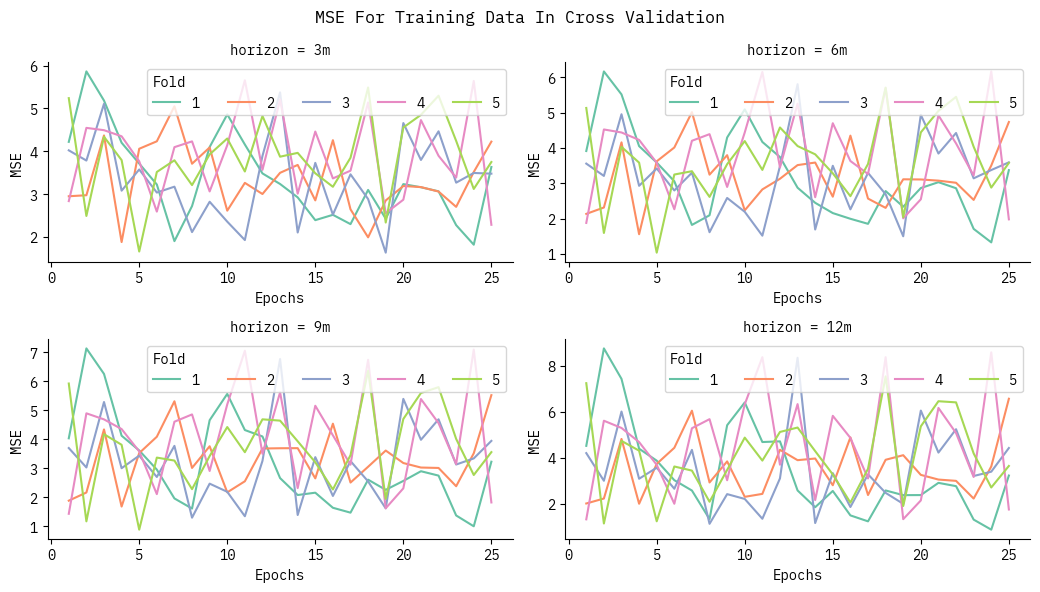

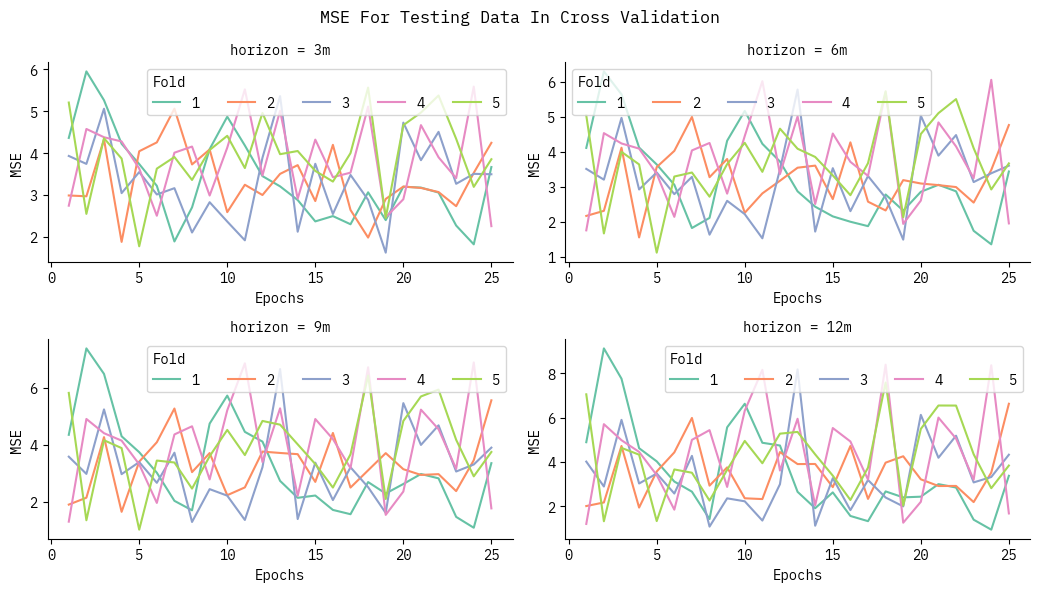

In [ ]:
with open('models/callback.json', 'r') as f:
    history = json.load(f)
    
for split in ['train', 'test']:
    dfs = []
    for fold in history:
        df = pd.DataFrame(history[fold][split])
        df.insert(0, 'epochs', range(1, len(df)  + 1))
        df.insert(0, 'fold', fold)
        dfs.append(df)
    df = pd.concat(dfs)
    df.to_csv
    plot_loss(df, split)

In [ ]:
def evaluate(y_true, y_pred):
    return [
        mean_squared_error(y_true, y_pred),
        root_mean_squared_error(y_true, y_pred),
        mean_absolute_error(y_true, y_pred),
        r2_score(y_true, y_pred),
    ]

In [ ]:
def evaluate_metrics_by_horizon(data, model, horizons=[3, 6, 9, 12]):
    y_preds = autoregressive_forecast(data, model)
    y_true = np.stack([data[:, 3 + h, :18] for h in range(4)], axis=1)
    metrics_per_horizon = {}
    for i, h in enumerate(horizons):
        metrics_per_horizon[f"{h}m"] = evaluate(y_true[:, i], y_preds[:, i])
    return metrics_per_horizon

In [ ]:
metrics = {'train': {}, 'test': {}}

for i, (train_idx, test_idx) in enumerate(kfold.split(np.zeros((data.shape[0], 1)))):
    print(f"[INFO] Evaluating on Fold {i+1}")
    model = build_transformer_model()
    model.load_weights(f'models/fold_{i+1}/model.h5')
    callbacks = [
        ModelCheckpoint(
            f"{model_dir}/model.h5",
            save_best_only=True,
            save_weights_only=True,
            verbose=False,
        ),
        TrainingCallback(train_idx, test_idx),
    ]
    metrics['train'][i+1] = evaluate_metrics_by_horizon(data[train_idx], model)
    metrics['test'][i+1] = evaluate_metrics_by_horizon(data[test_idx], model)

[INFO] Evaluating on Fold 1
[INFO] Evaluating on Fold 2
[INFO] Evaluating on Fold 3
[INFO] Evaluating on Fold 4
[INFO] Evaluating on Fold 5


In [ ]:
os.makedirs('results', exist_ok=True)

In [ ]:
METRICS = ['MSE', 'RMSE', "MAE", 'R2-Score']

metrics_df = []
for split in ['train', 'test']:
    dfs = []
    for fold in metrics[split]:
        df = pd.DataFrame(metrics[split][fold])
        df.insert(0, 'Metrics', METRICS)
        df.insert(0, 'Fold', fold)
        dfs.append(df)
    df = pd.concat(dfs)
    df.insert(0, 'Split', split.title())
    metrics_df.append(df)

metrics_df = pd.concat(metrics_df)
metrics_df.to_csv('results/all_metrics.csv', index=False)

In [ ]:
def plot_metrics(df, metric):
    ylims = {'MSE': [1.5, 5], 'RMSE': [0.6, 1.5], 'MAE': [0.75, 1], 'R2-Score': [0.3, 1]}
    df = df[df['Metrics'] == metric].copy()
    df.drop('Metrics', axis=1, inplace=True)
    df_melt = df.melt(id_vars=['Fold', 'Split'])
    g = sbn.FacetGrid(df_melt, col='Split', sharex=False, sharey=False, height=4, aspect=1.25)
    g.map_dataframe(sbn.barplot, x='variable', y='value', hue='Fold', palette='tab10')
    for ax in g.axes.flat:
        ax.grid(True)
        for p in ax.patches:
            p.set_edgecolor('k')
            p.set_linewidth(1)
            p.set_zorder(1000)
        ax.legend(ncol=3)
        ax.get_legend().set_title("Fold")
        ax.get_legend()._legend_box.align = "left"
        ax.set_xlabel('Horizon')
        ax.set_ylim(ylims[metric])
    g.fig.suptitle(f'Metric = {metric}')
    g.fig.tight_layout()
    g.fig.savefig(f'results/{metric}.png')

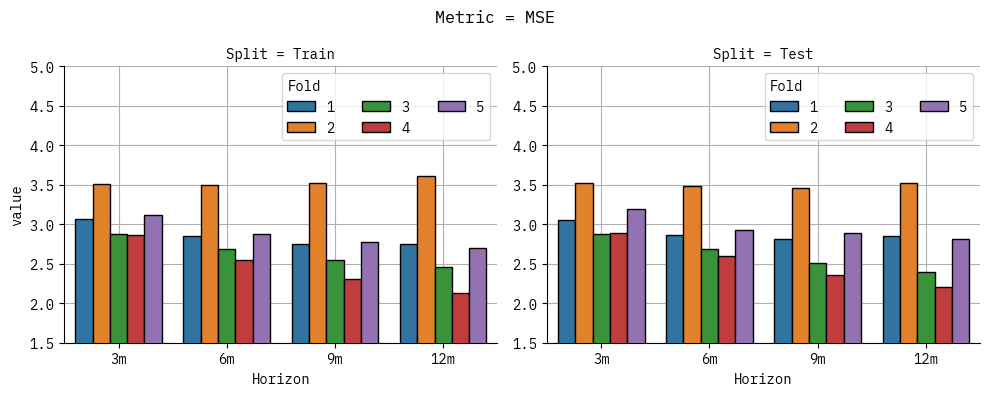

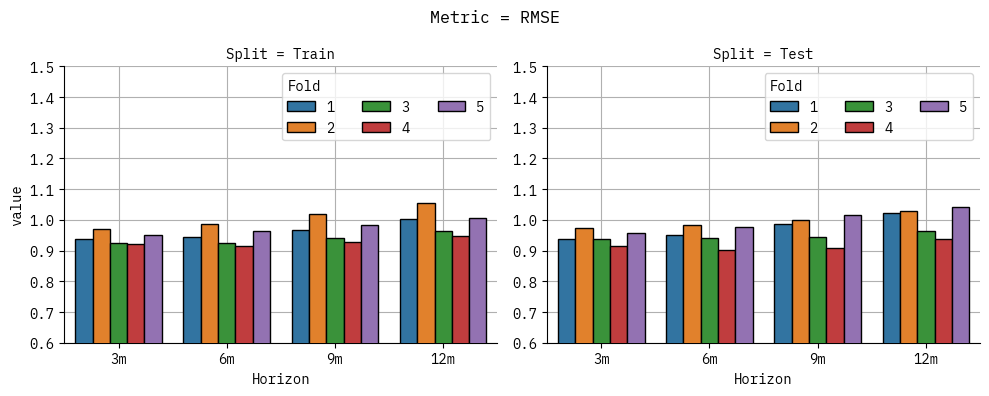

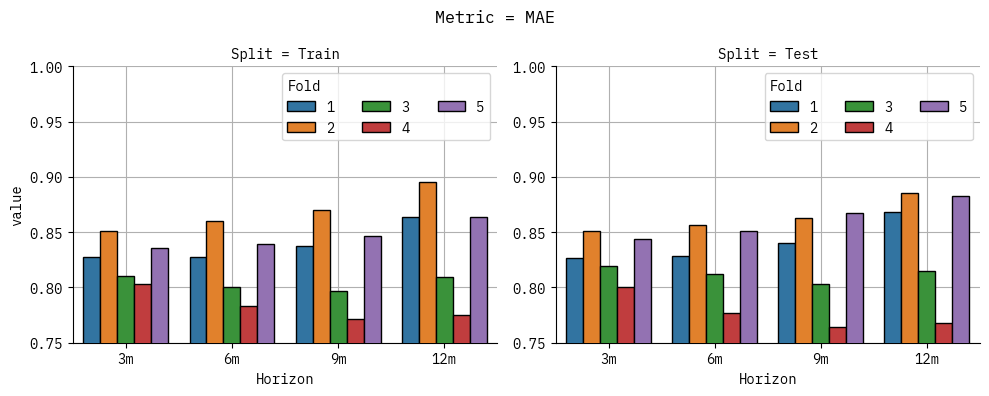

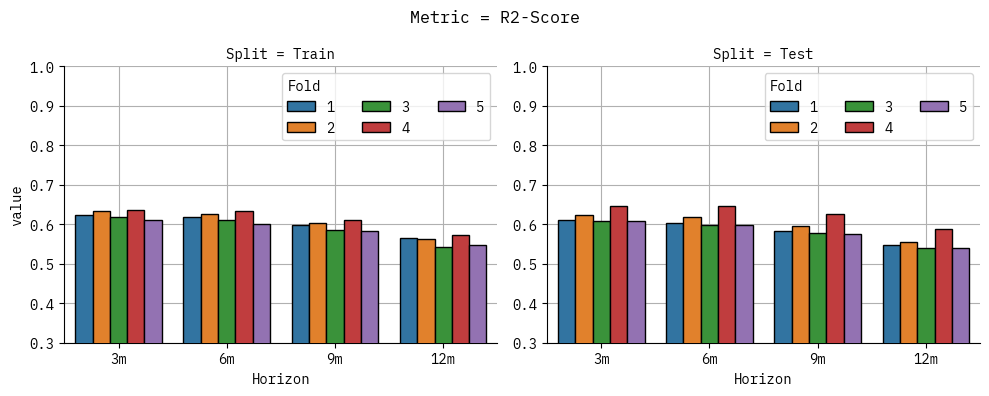

In [ ]:
for metric in METRICS:
    plot_metrics(metrics_df, metric)

In [ ]:
df_r2_test = metrics_df[
    (metrics_df["Metrics"] == "R2-Score") &
    (metrics_df["Split"] == "Test")
].copy()
df_r2_test["avg_r2"] = df_r2_test[["3m", "6m", "9m", "12m"]].mean(axis=1)
df_r2_test.reset_index(drop=True, inplace=True)
best_row = df_r2_test["avg_r2"].idxmax()
best_fold = df_r2_test.loc[best_row]['Fold']
print(f'Best Fold :: {best_fold}')

Best Fold :: 4


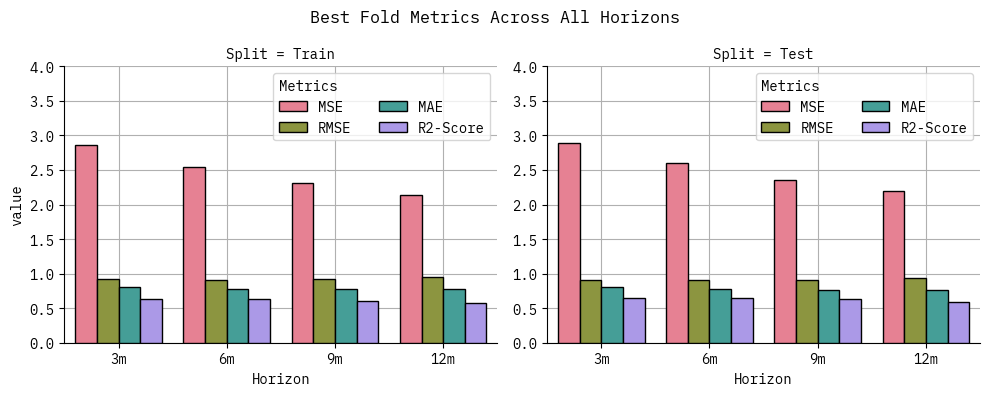

In [ ]:
fold_df = metrics_df[metrics_df['Fold'] == best_fold]
fold_df.drop('Fold', axis=1, inplace=True)
fold_df = fold_df.round(4)
fold_df.to_csv('results/best_metrics.csv', index=False)
fold_df_melt = fold_df.melt(id_vars=['Split', 'Metrics'])
g = sbn.FacetGrid(fold_df_melt, col='Split', sharex=False, sharey=False, height=4, aspect=1.25)
g.map_dataframe(sbn.barplot, x='variable', y='value', hue='Metrics', palette='husl')
for ax in g.axes.flat:
    ax.grid(True)
    for p in ax.patches:
        p.set_edgecolor('k')
        p.set_linewidth(1)
        p.set_zorder(1000)
    ax.legend(ncol=2)
    ax.get_legend().set_title("Metrics")
    ax.get_legend()._legend_box.align = "left"
    ax.set_xlabel('Horizon')
    ax.set_ylim(0, 4)
g.fig.suptitle('Best Fold Metrics Across All Horizons')
g.fig.tight_layout()
g.fig.savefig('results/best_metrics.png')

In [ ]:
def autoregressive_forecast_multiple_horizons(
    model,
    patient_data,
    static_feature_indices=[18, 19, 20, 21],
    input_steps=4,
    horizons=[3, 6, 9, 12],
):
    temporal_indices = np.setdiff1d(
        np.arange(patient_data.shape[1]), static_feature_indices
    )
    x_seq = patient_data[:input_steps].copy()
    static_values = patient_data[0, static_feature_indices]
    pred_outputs = []
    all_preds = []
    for month in range(1, max(horizons) + 1):
        static_repeated = np.repeat(static_values[np.newaxis, :], input_steps, axis=0)
        x_model = np.concatenate([x_seq[:, temporal_indices], static_repeated], axis=1)
        x_model = np.expand_dims(x_model, axis=0)
        pred = model.predict(x_model, verbose=0)[0]
        all_preds.append(pred)
        x_next = np.concatenate([pred, static_values])
        x_seq = np.concatenate([x_seq[1:], [x_next]], axis=0)
        if month in horizons:
            pred_outputs.append(pred)
    return np.array(pred_outputs)

In [143]:
def plot_actual_vs_pred_for_patient(
    pid, static_feature_indices=[18, 19, 20, 21], input_steps=4, horizons=[3, 6, 9, 12]
):
    for i, (_, test_idx) in enumerate(kfold.split(np.zeros((data.shape[0], 1)))):
        if best_fold == i + 1:
            patient_data = data[test_idx][pid]
            y_pred = autoregressive_forecast_multiple_horizons(model, patient_data)[
                :, 10
            ].ravel()
            y_pred = np.array([*patient_data[:4, 10].ravel(), *y_pred])
            temporal_indices = np.setdiff1d(
                np.arange(patient_data.shape[1]), static_feature_indices
            )
            y_actual = []
            for h in horizons:
                idx = input_steps + h - 1
                y_actual.append(patient_data[idx, temporal_indices])
            y_actual = np.array(y_actual)[:, 10]
            y_actual = np.array([*patient_data[:4, 10].ravel(), *y_actual])
            x = [0, 1, 2, 3, 6, 9, 12, 15]
            fig = plt.figure(figsize=(8, 4))
            ax = fig.gca()
            ax.plot(x, y_actual, c="green", marker="o", label="Actual")
            ax.plot(x, y_pred, ls='--', c="blue", marker="s", label="Predicted")
            ax.plot(x[:4], y_actual[:4], c="k", marker="o", label="First 3 Months")
            ax.set_title(f"Patient #{pid + 1}")
            ax.set_ylabel("ALSFRS Total Score")
            ax.grid(True)
            ax.set_xticks(
                [0, 1, 2, 3, 6, 9, 12, 15],
                [
                    "0\n(1st visit)",
                    "1",
                    "2",
                    "3",
                    "6\n(+3 months)",
                    "9\n(+6 months)",
                    "12\n(+9 months)",
                    "15\n(+12 months)",
                ],
            )
            ax.legend()
            fig.tight_layout()
            fig.savefig(f'results/predicted/{pid + 1}.png')

[INFO] Forecasting Patient ALS Progression :: 100%|██████████| 100/100 [02:57<00:00,  1.78s/it]


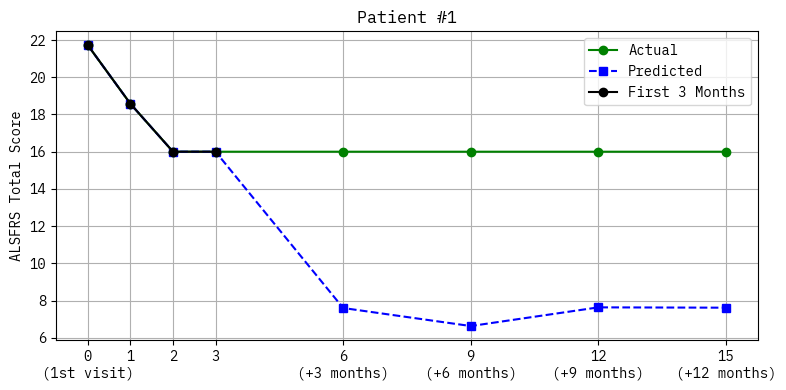

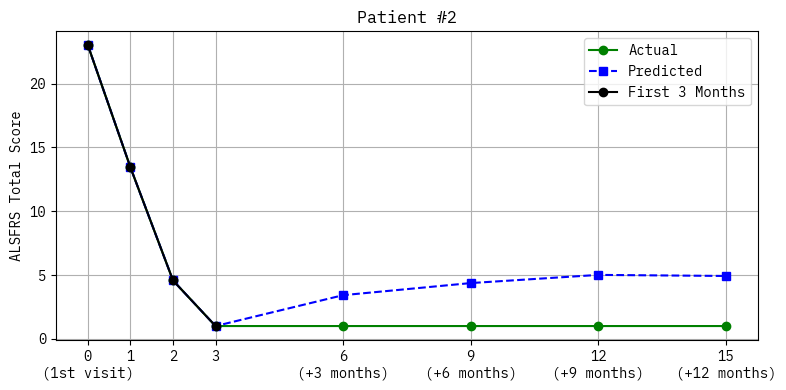

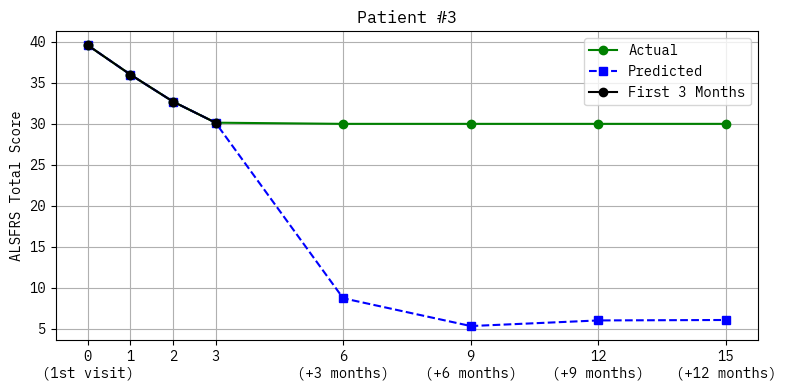

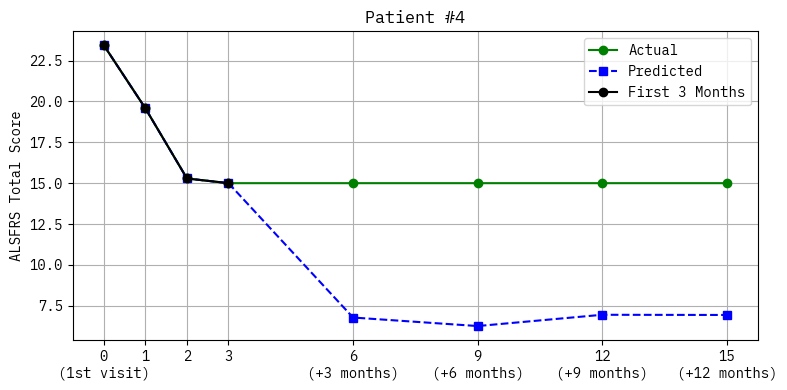

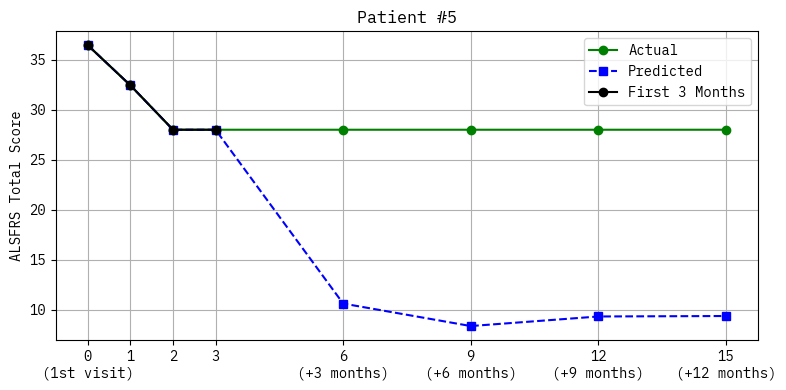

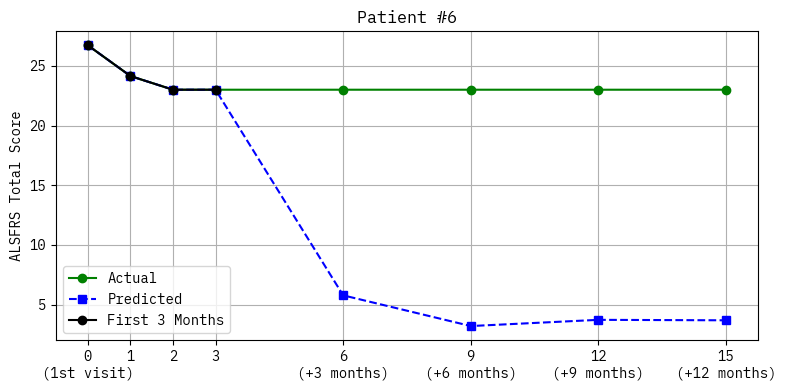

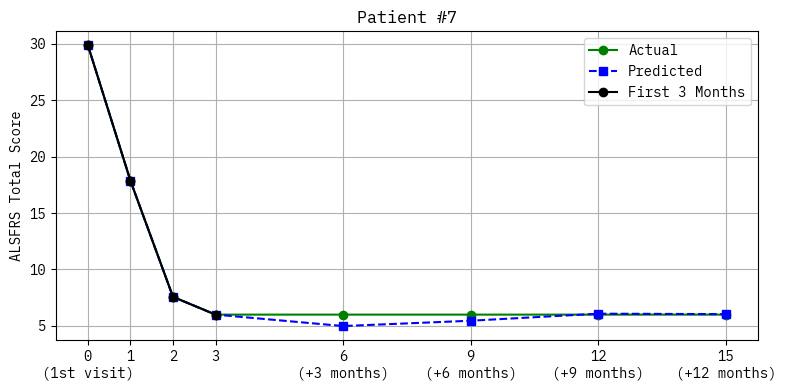

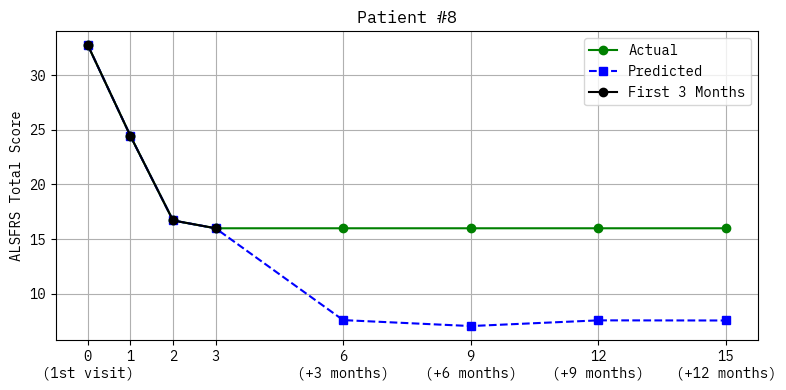

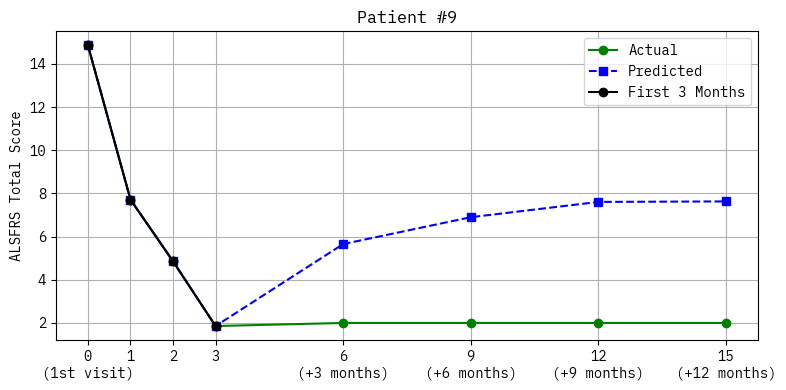

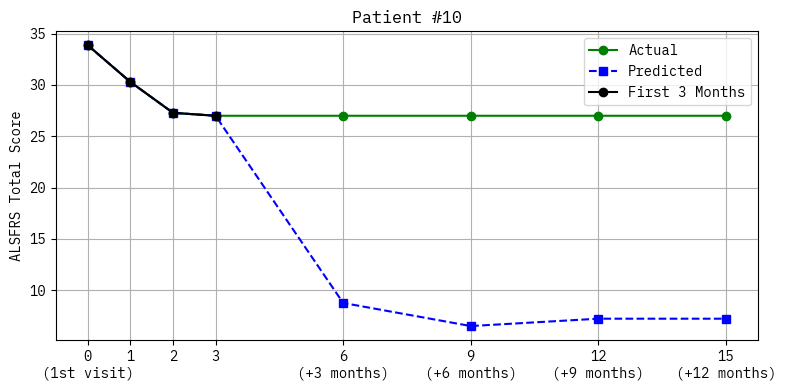

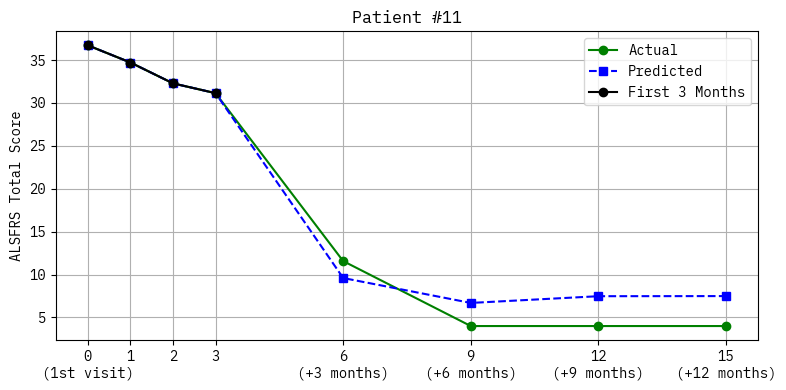

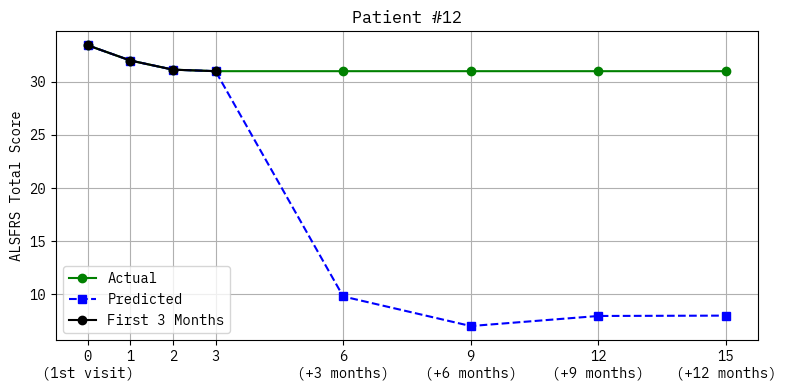

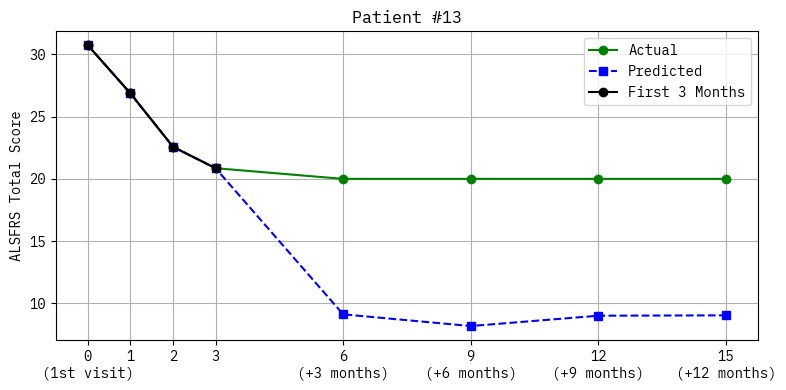

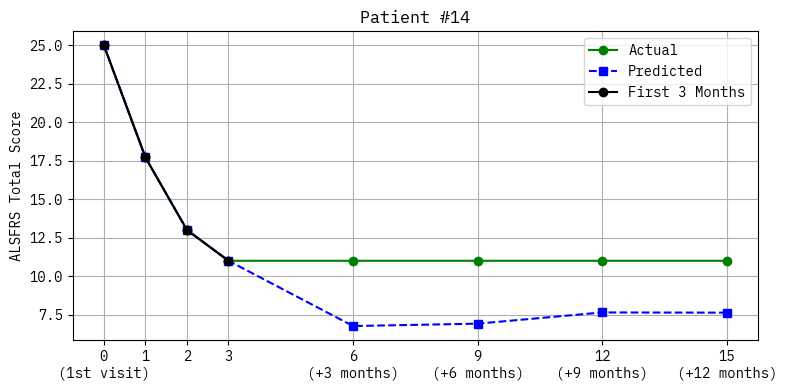

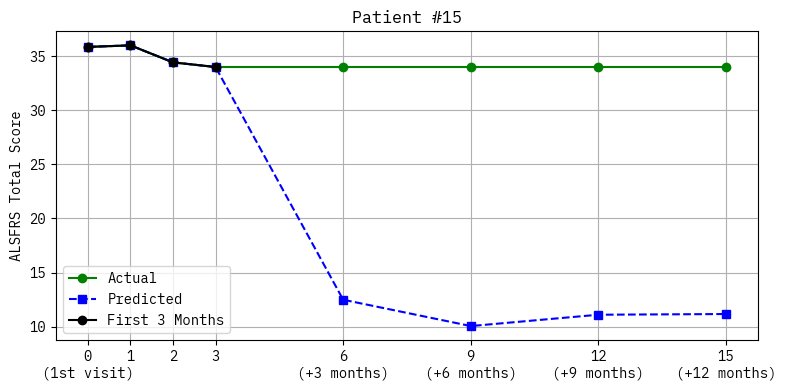

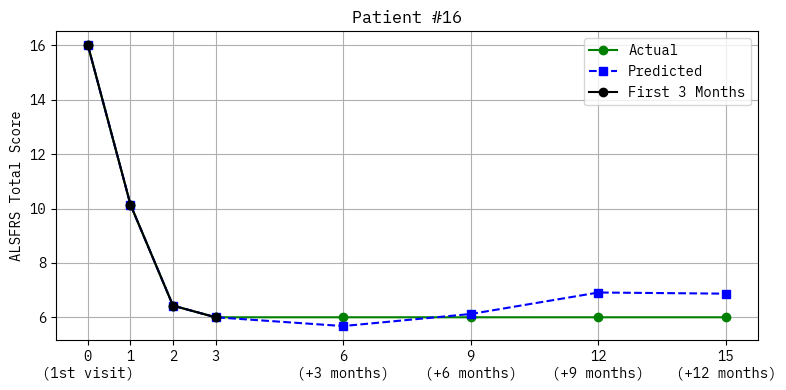

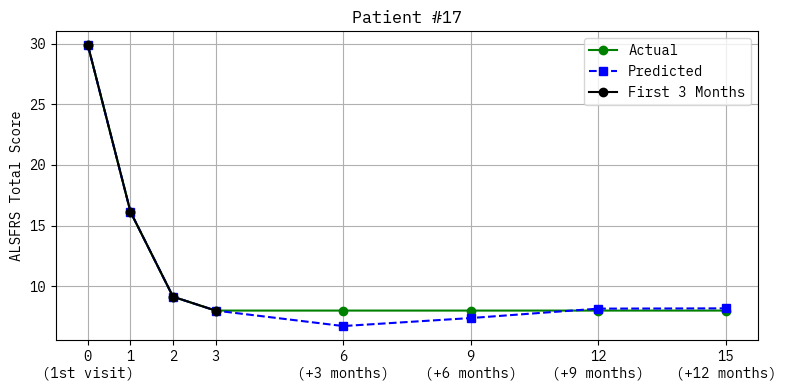

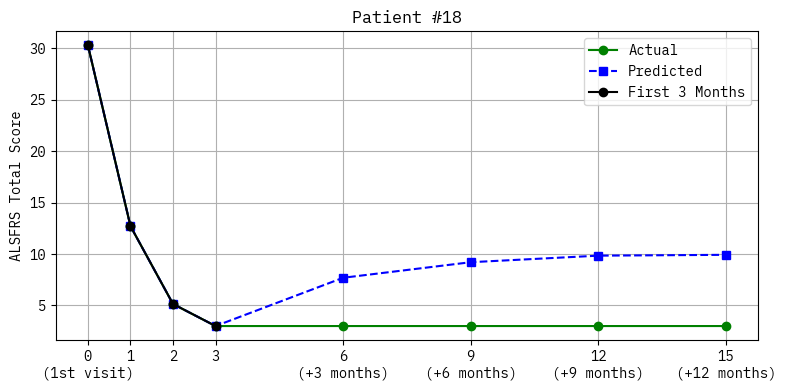

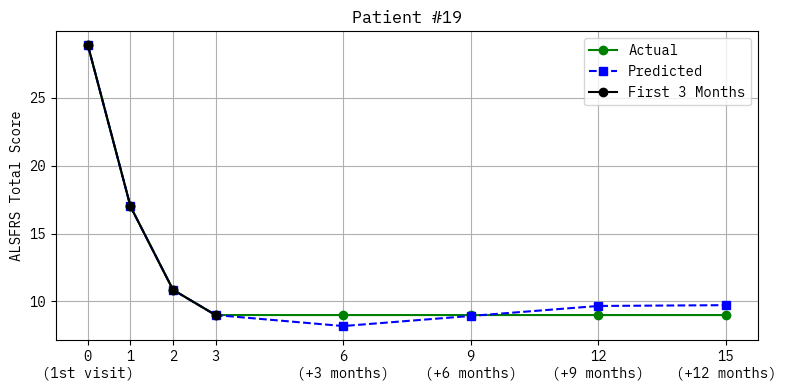

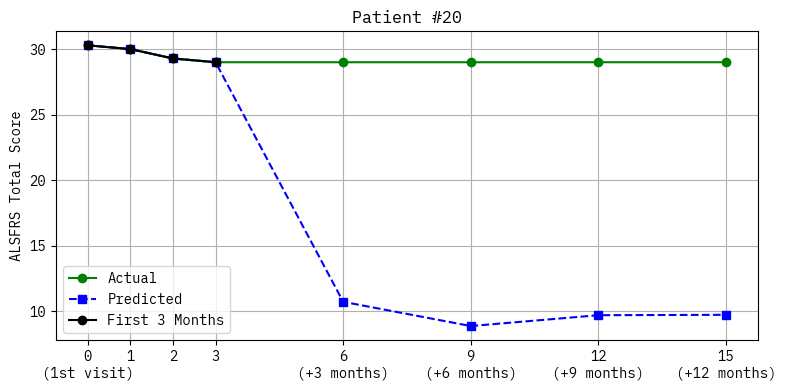

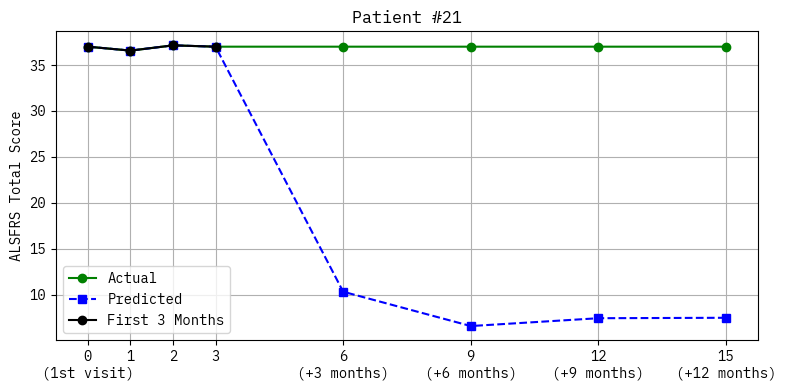

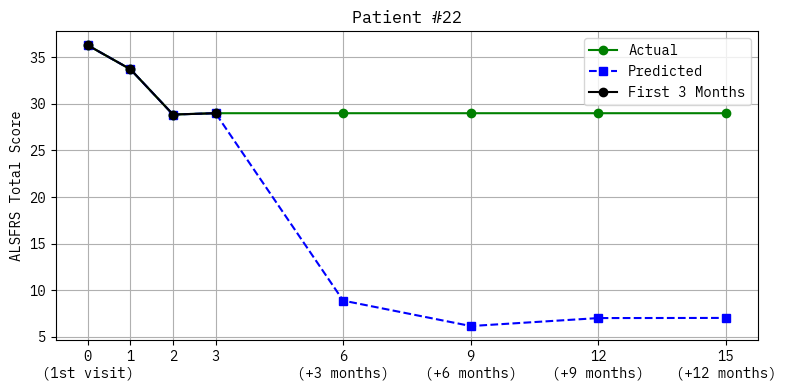

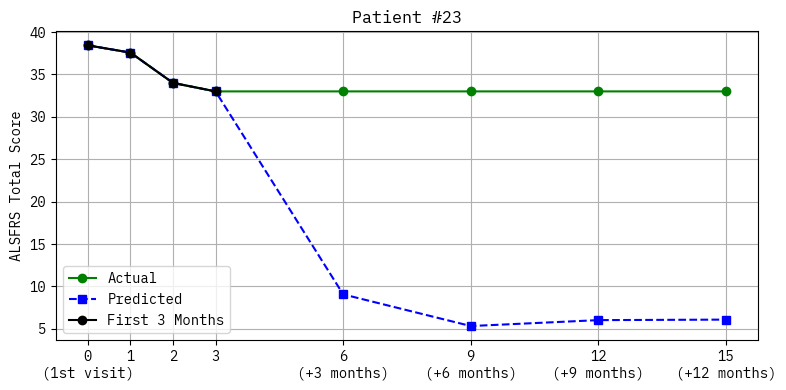

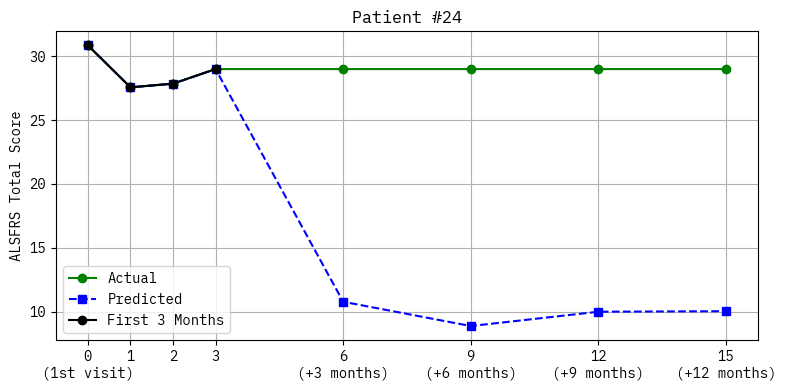

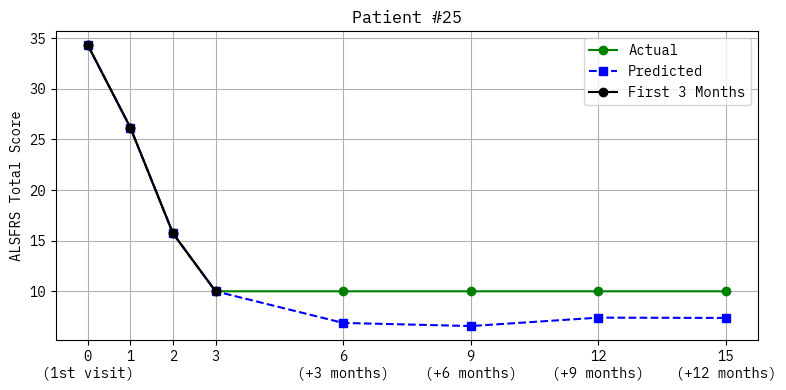

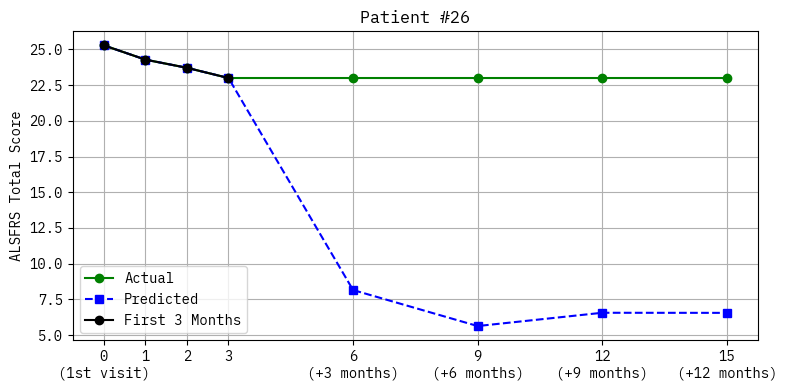

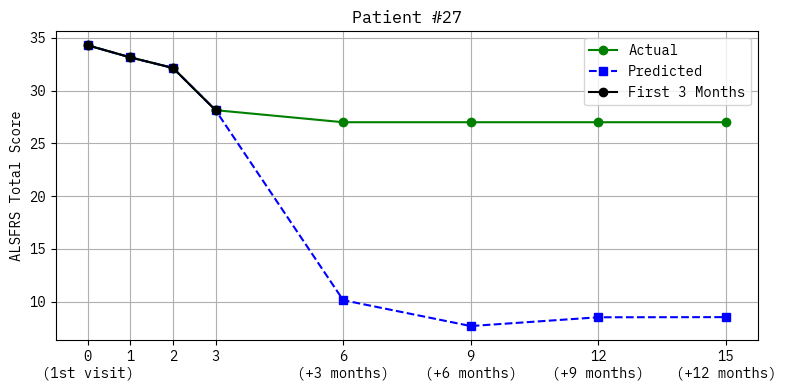

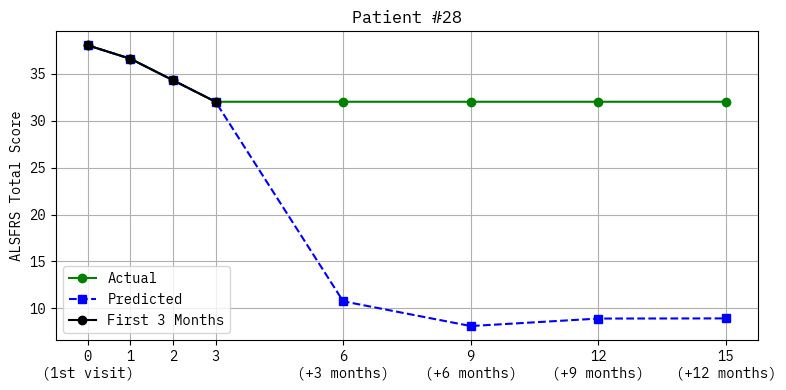

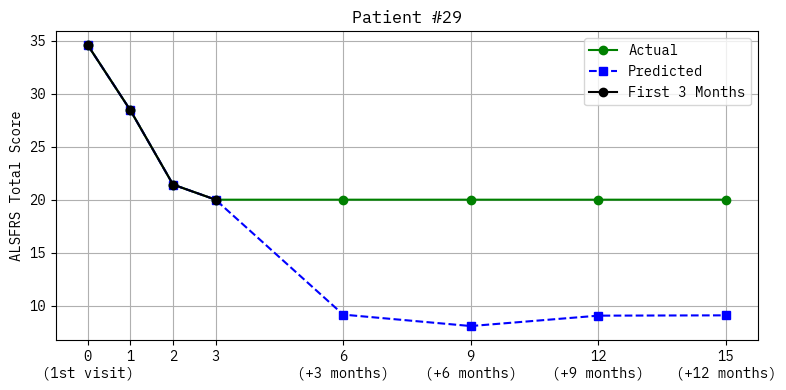

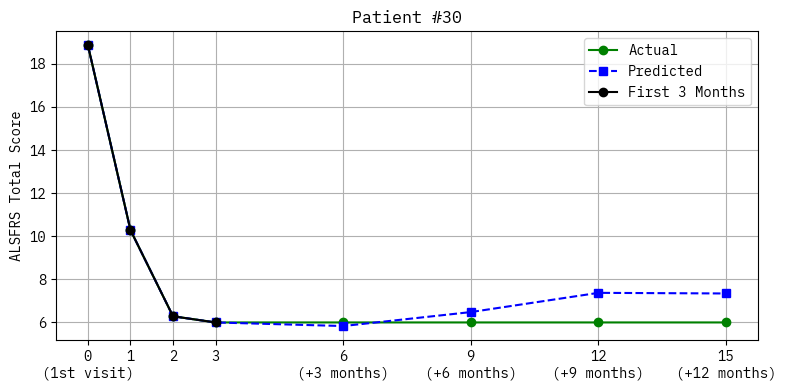

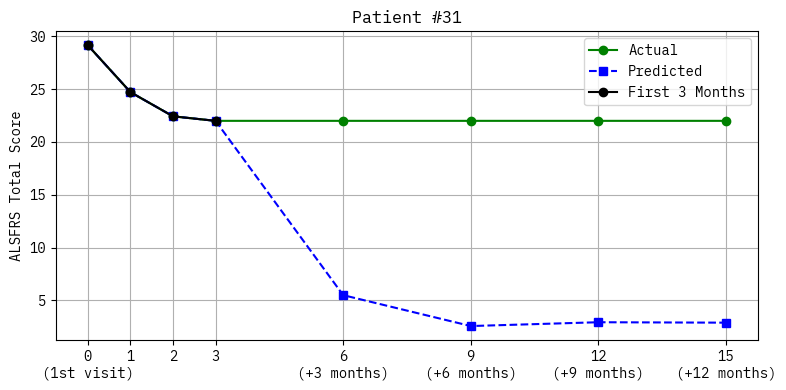

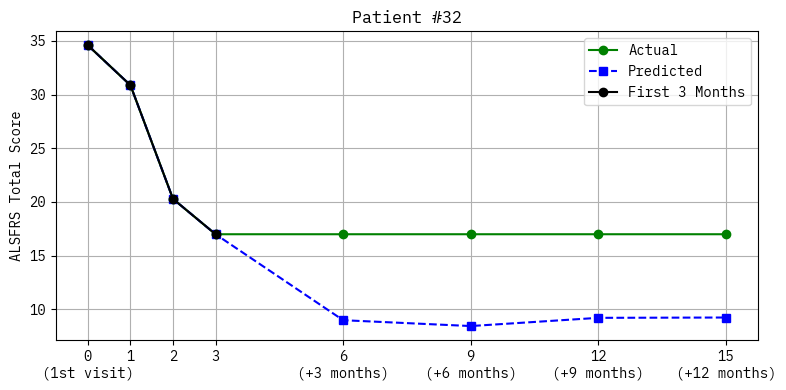

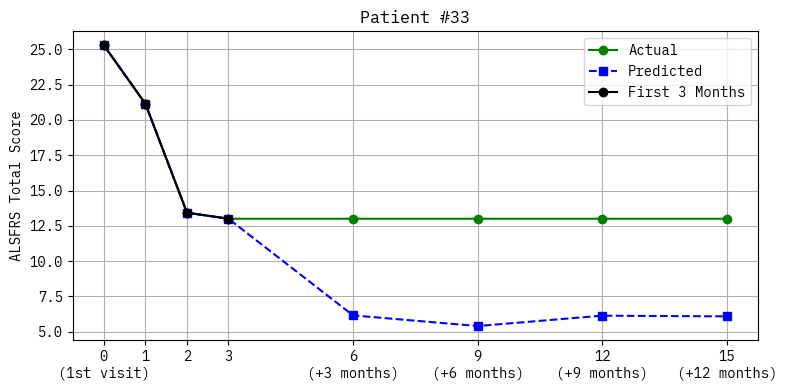

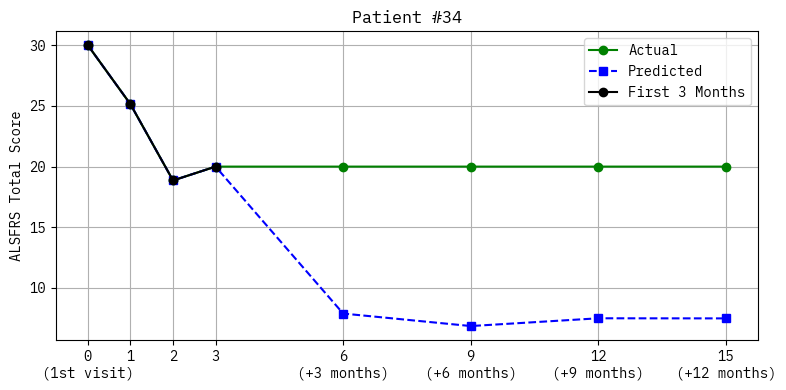

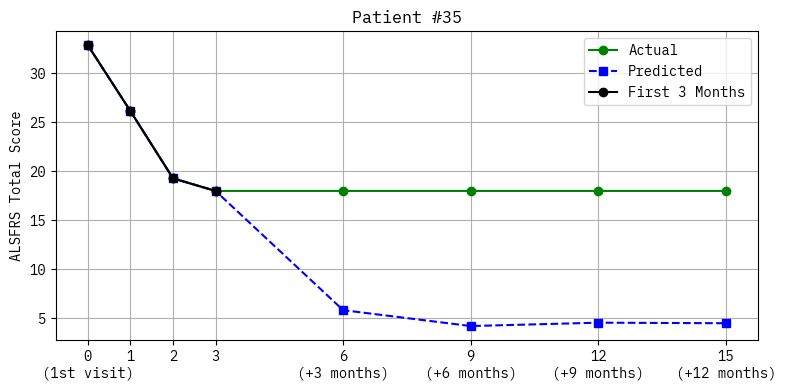

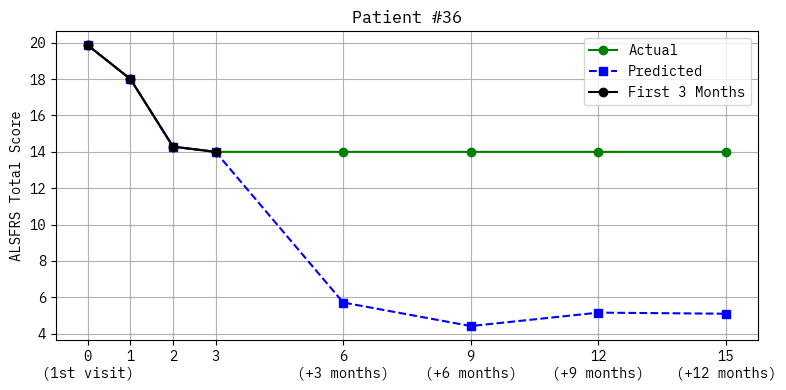

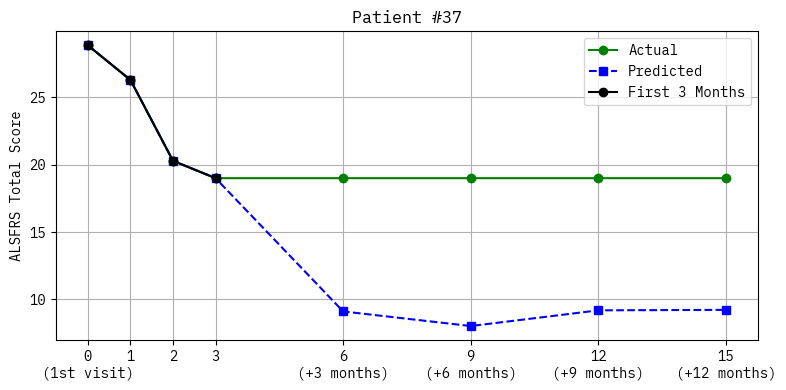

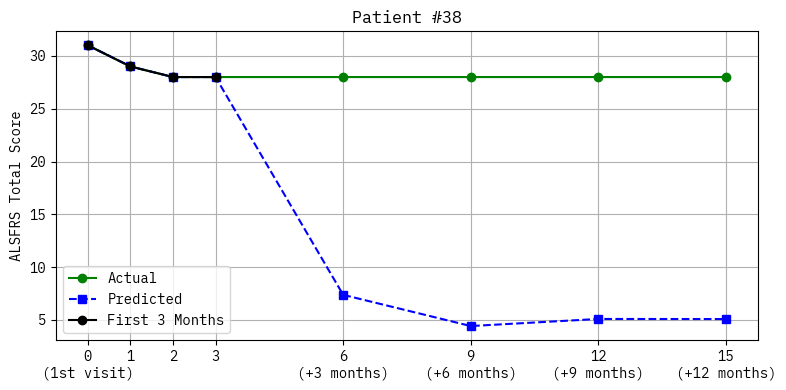

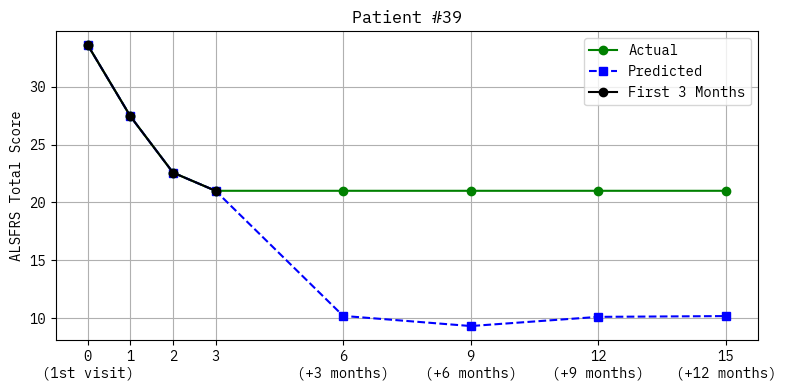

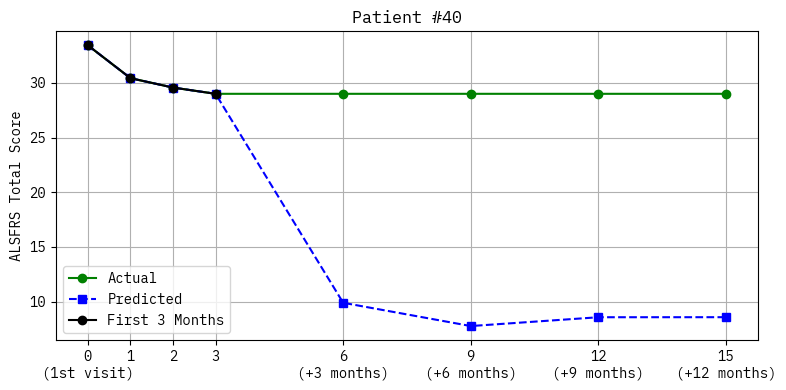

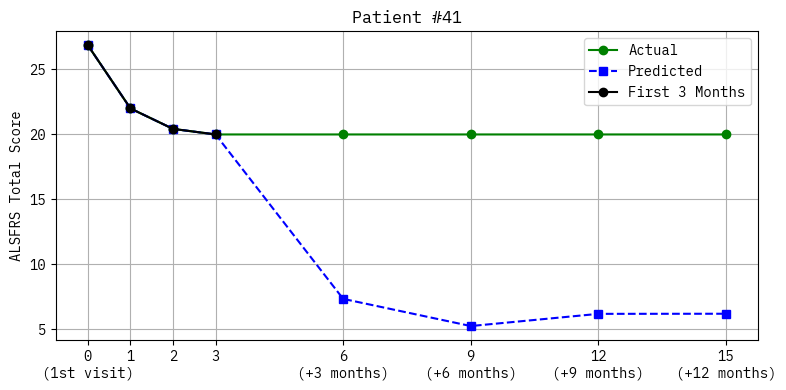

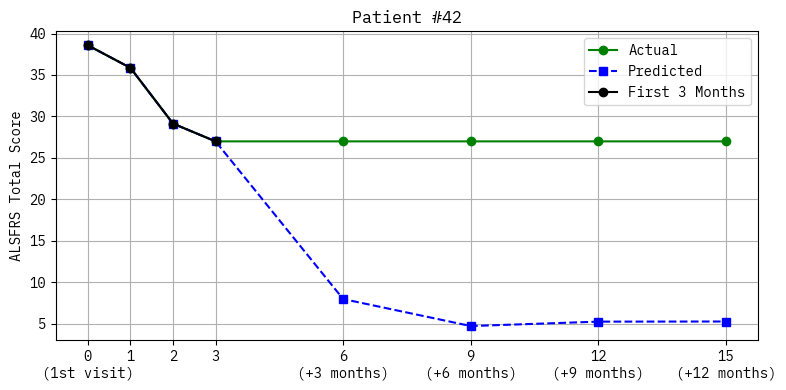

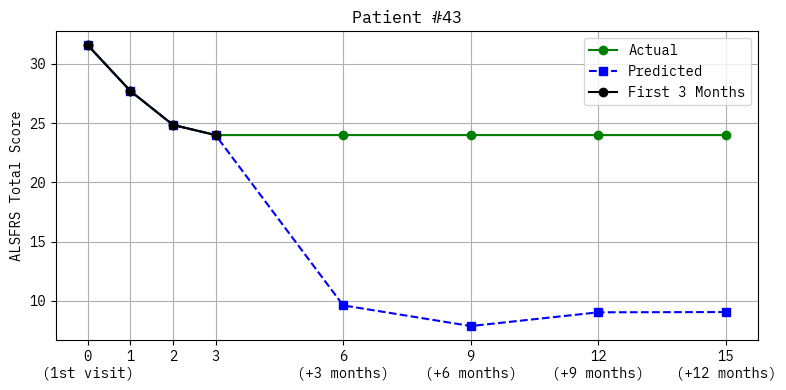

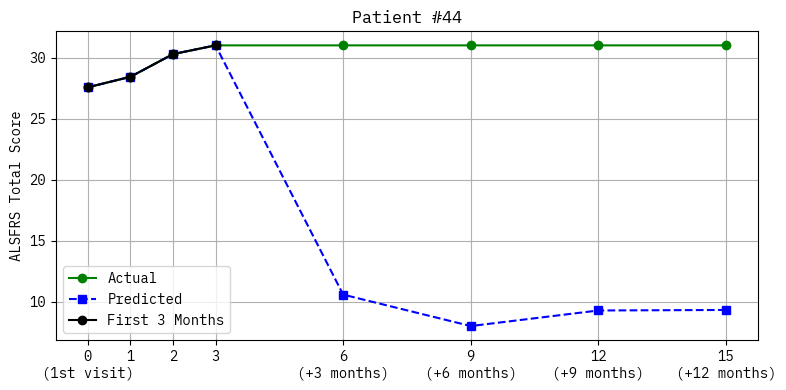

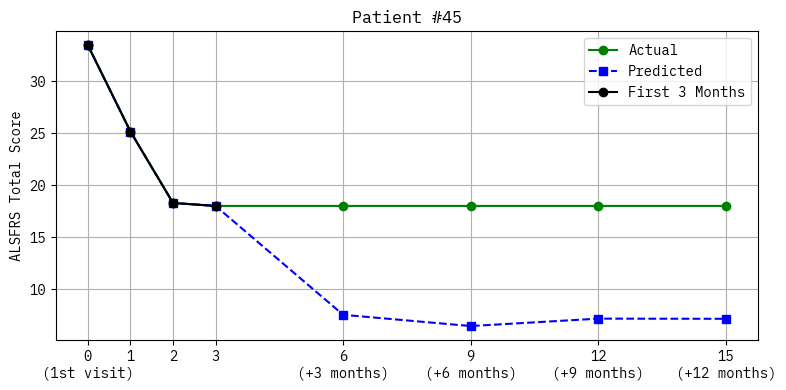

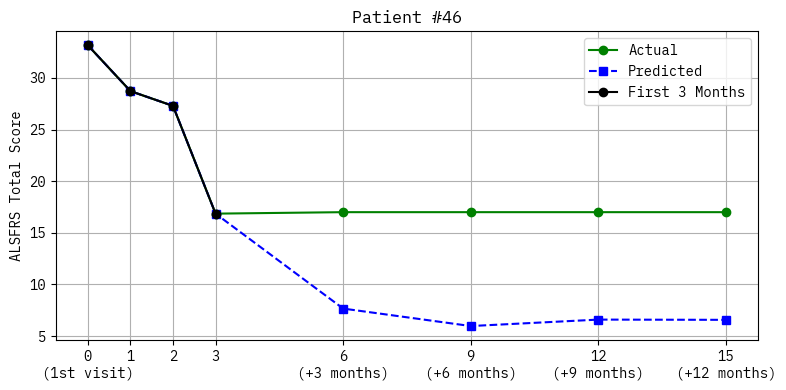

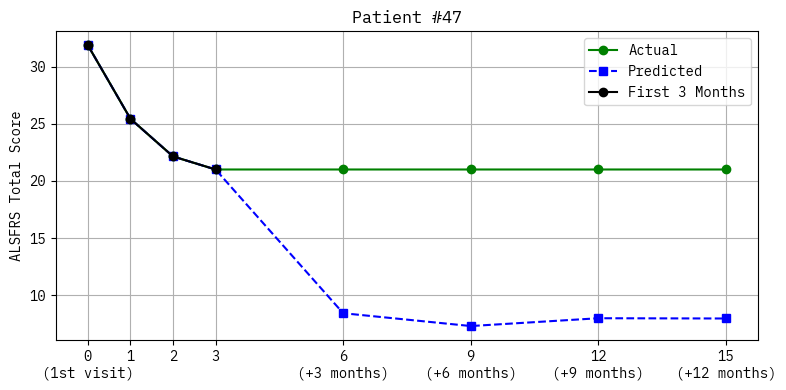

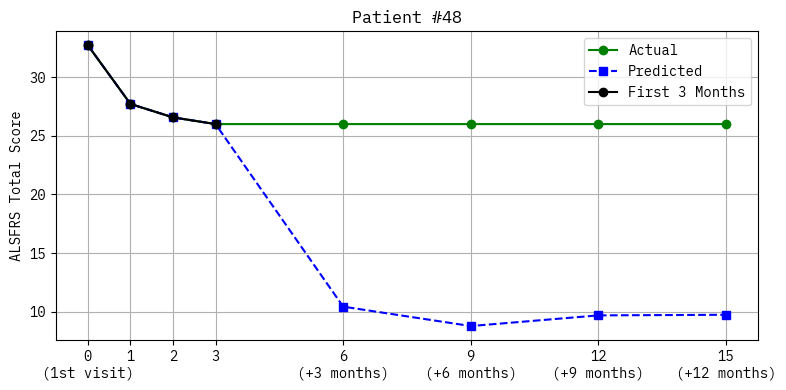

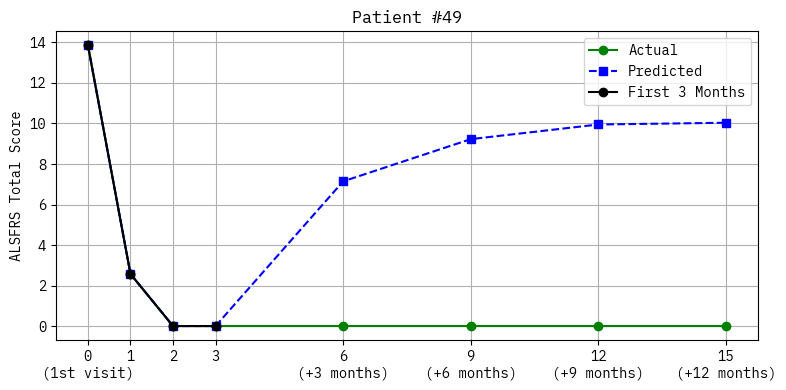

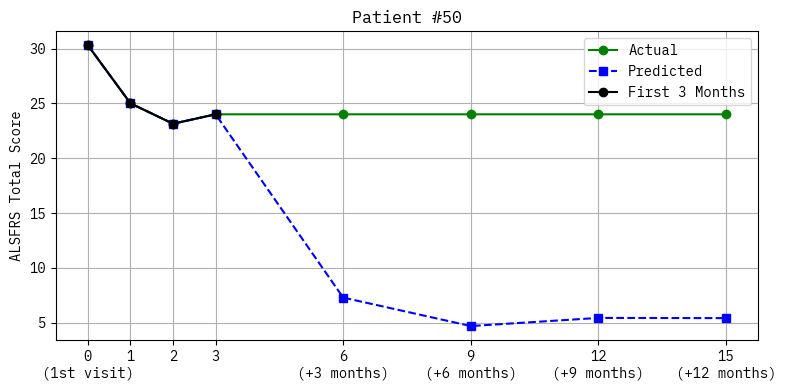

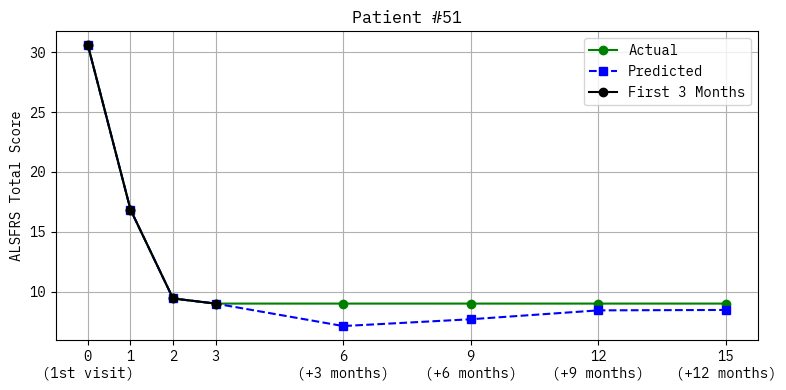

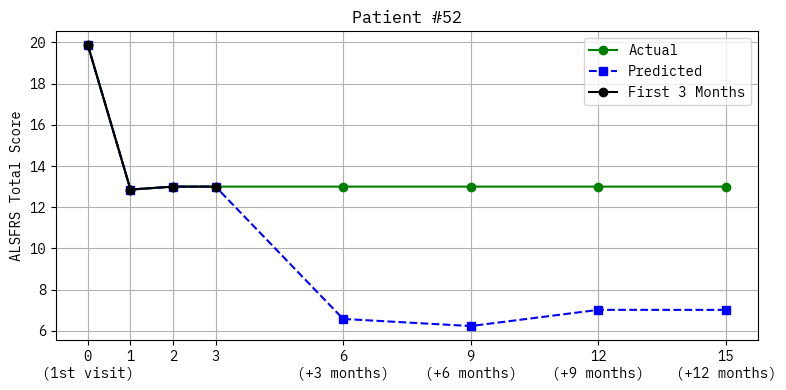

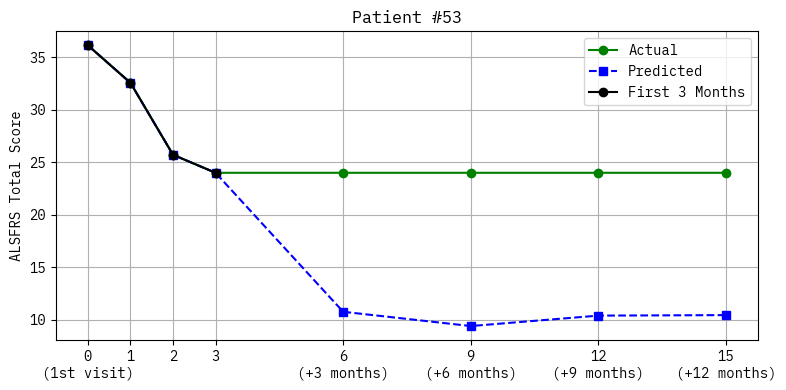

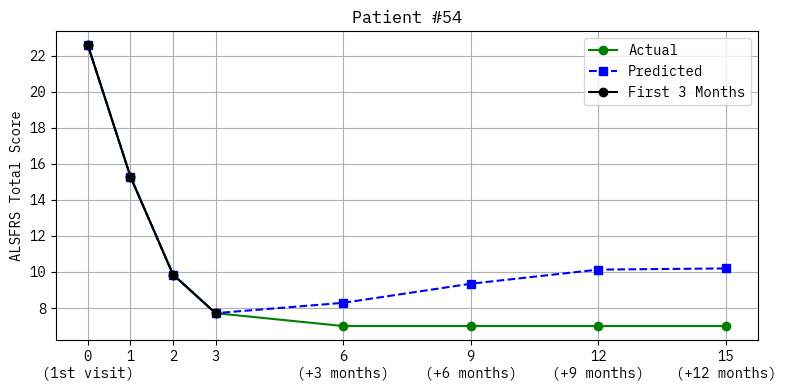

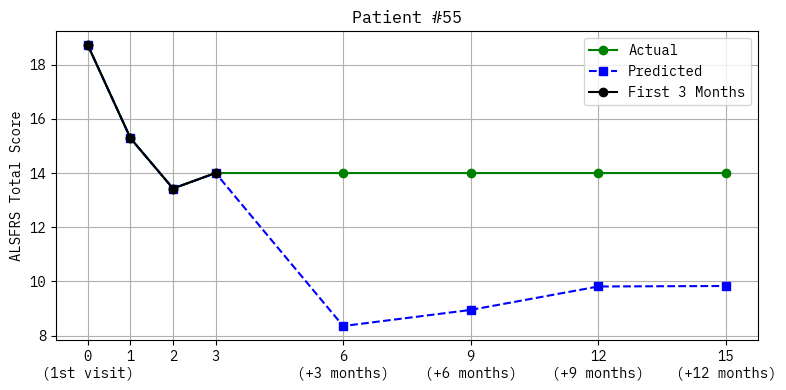

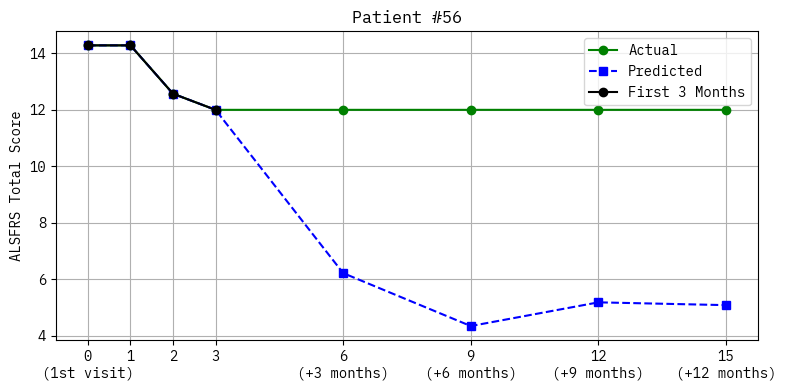

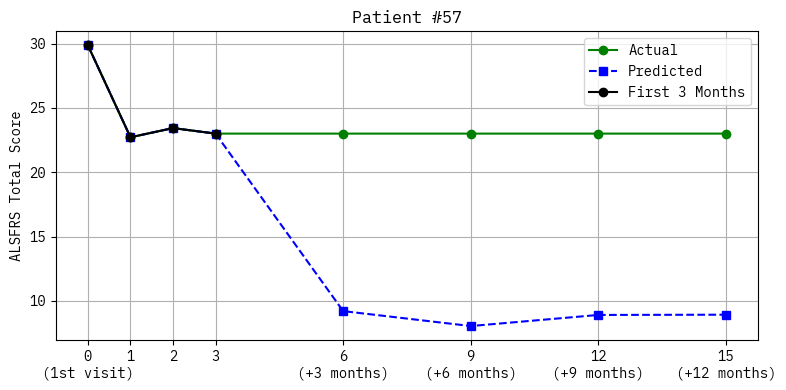

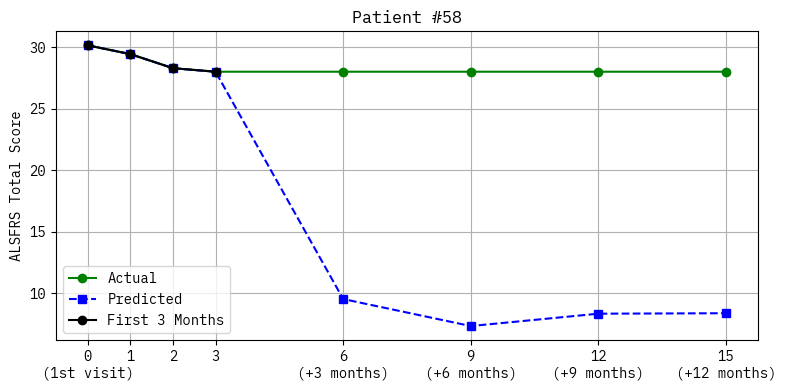

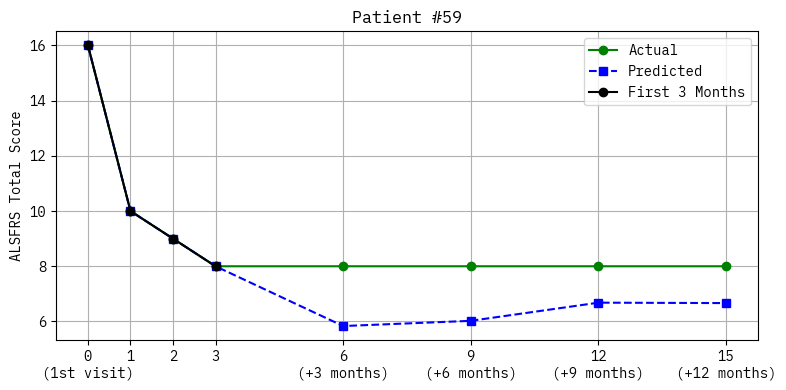

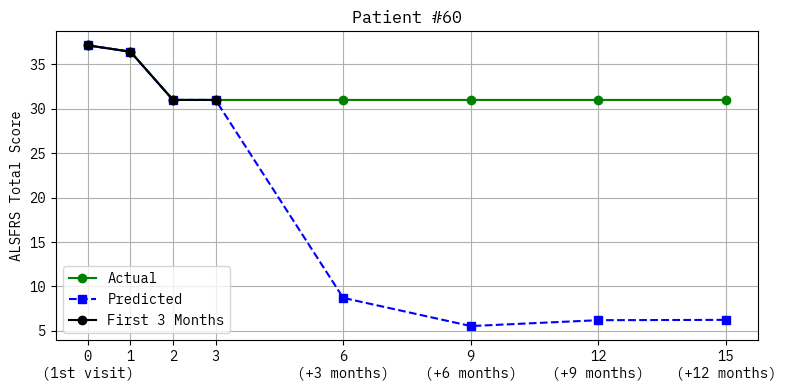

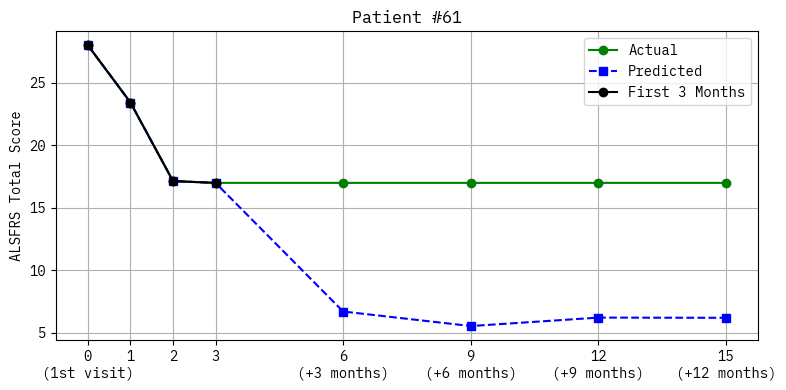

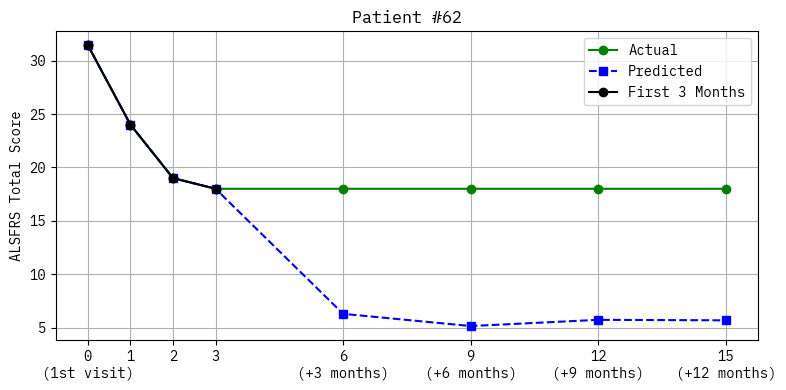

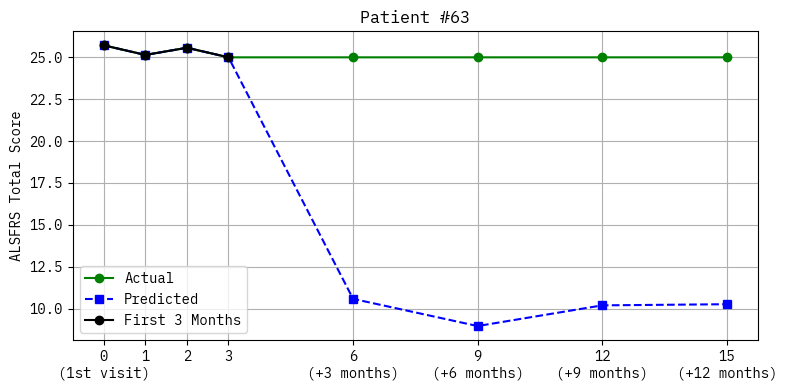

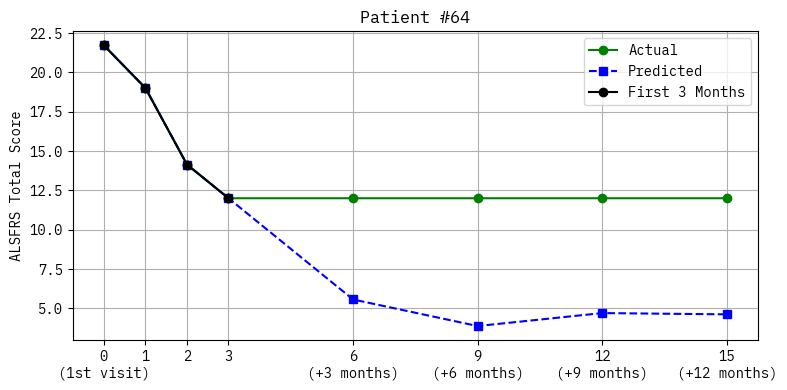

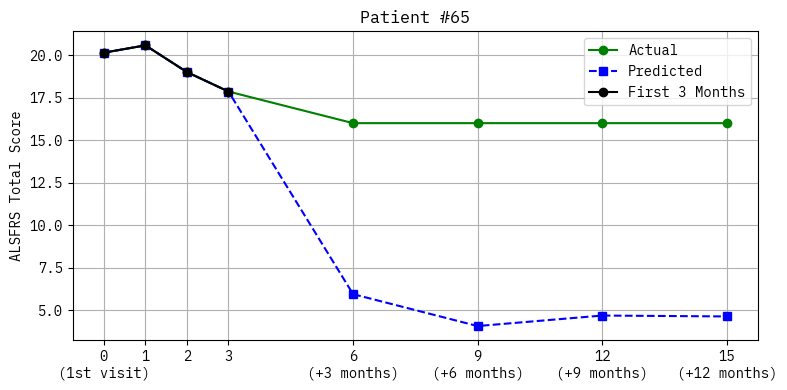

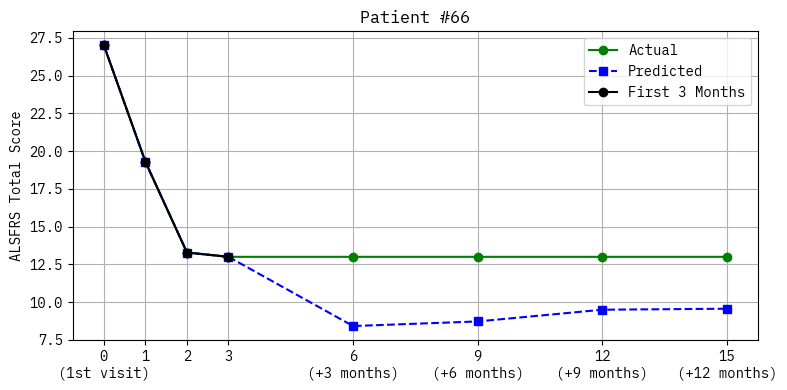

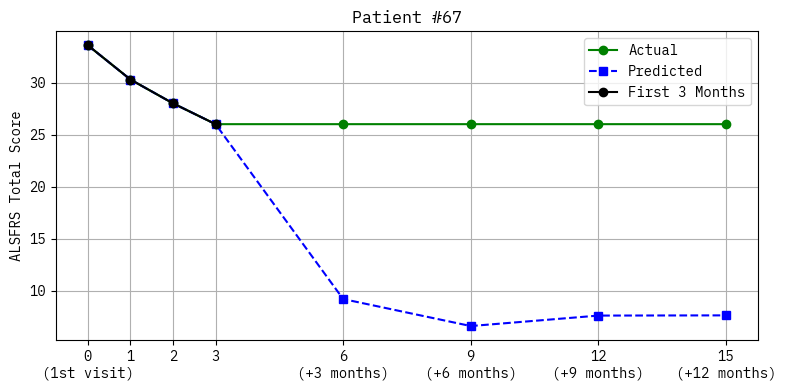

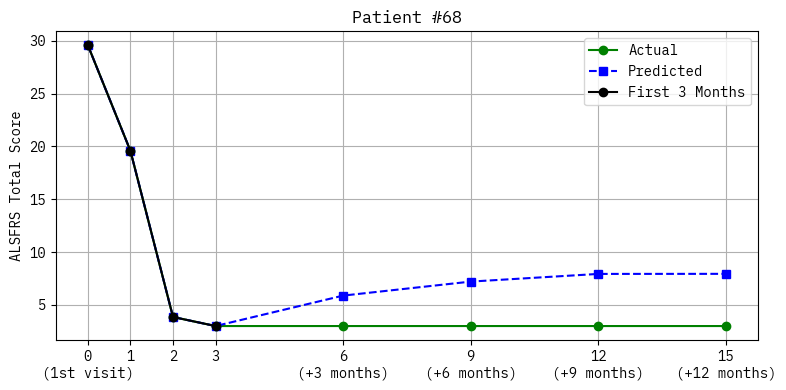

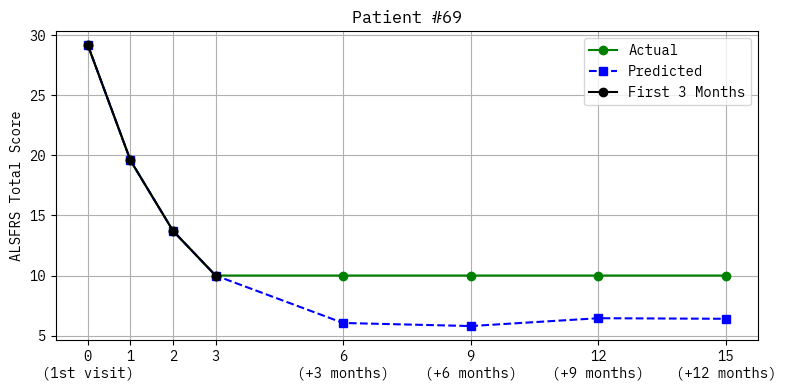

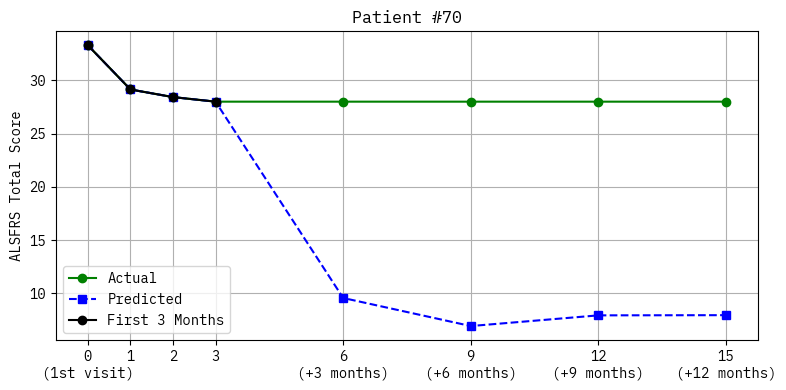

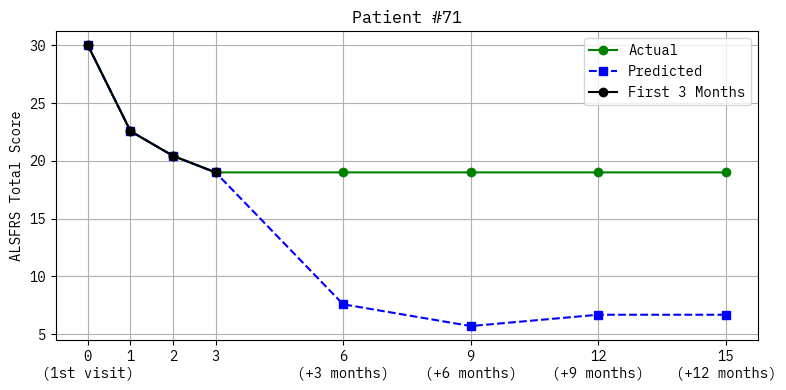

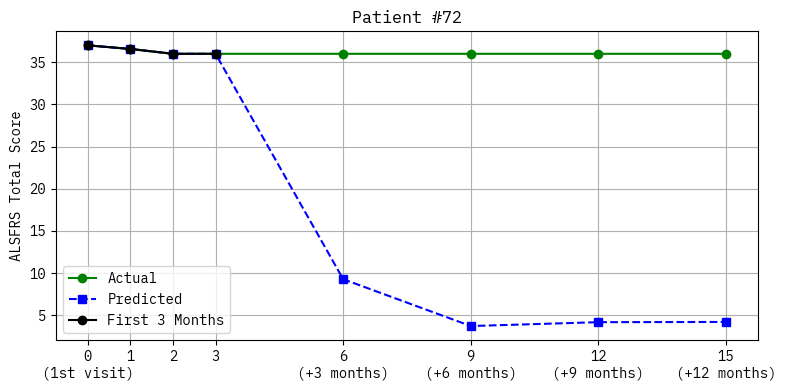

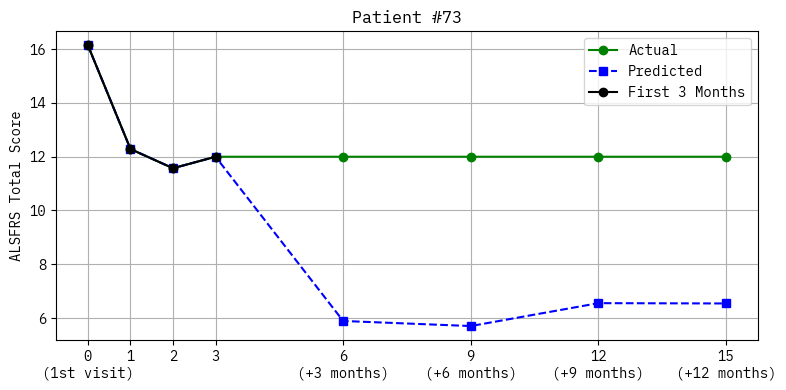

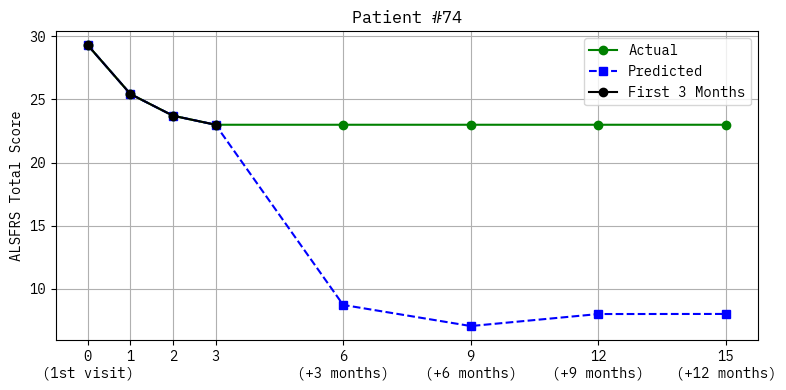

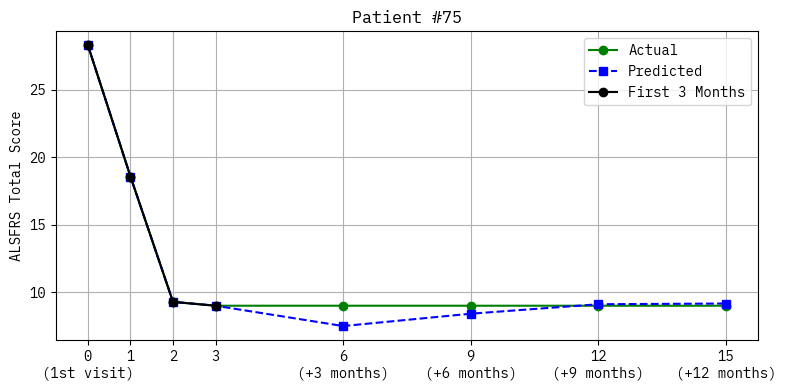

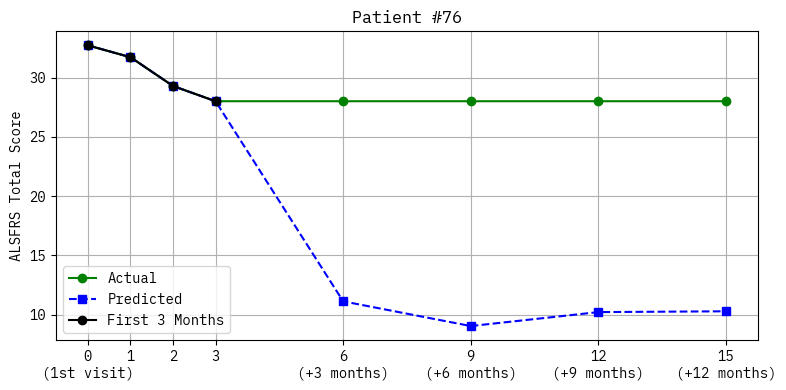

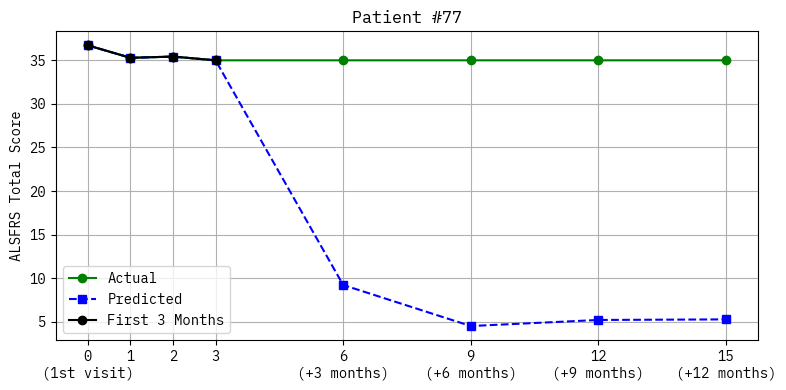

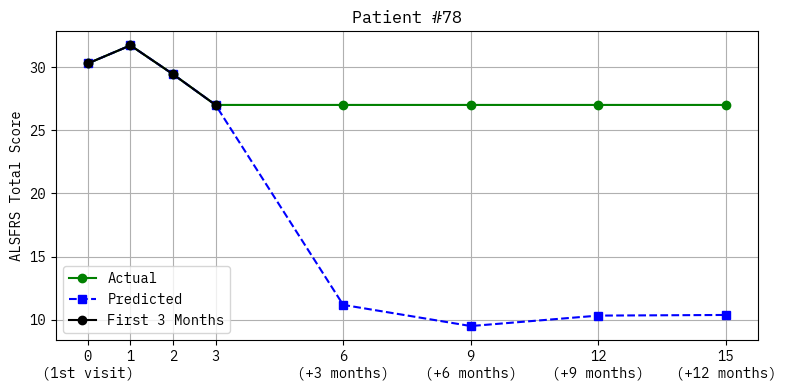

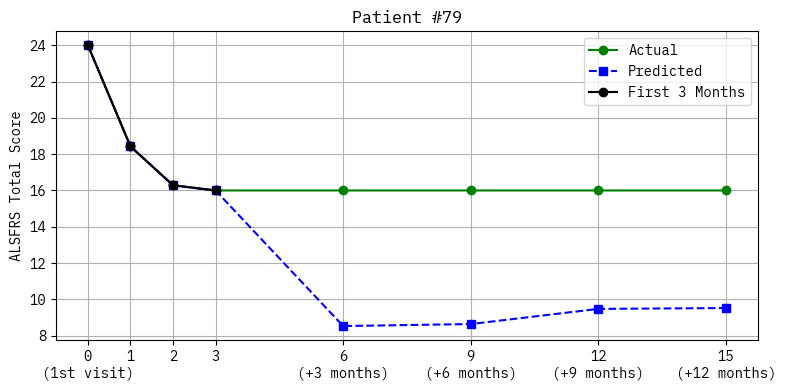

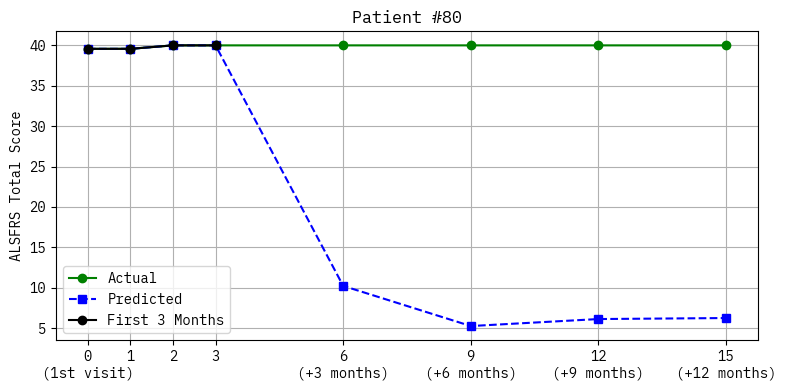

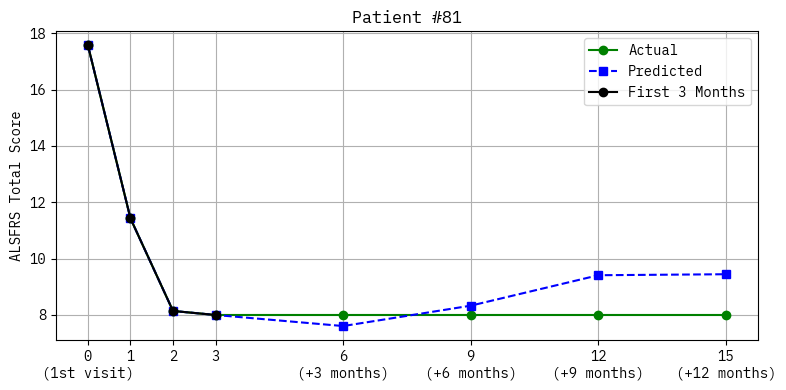

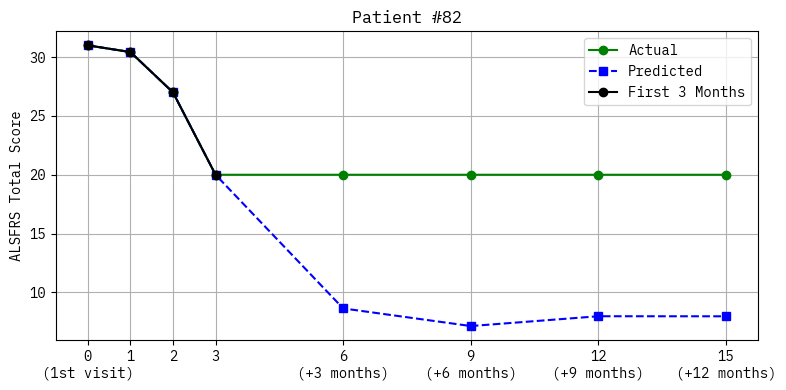

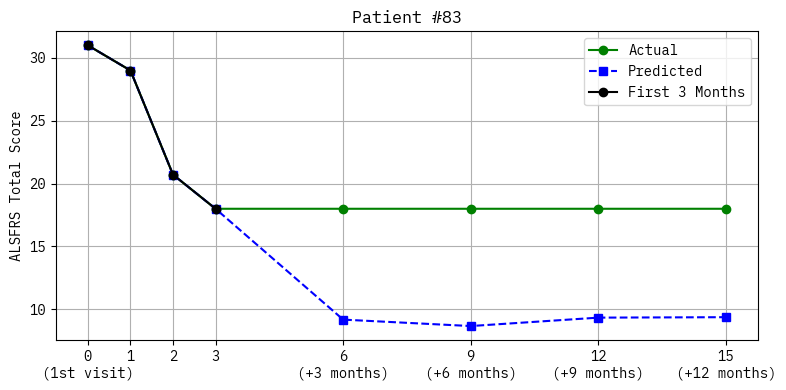

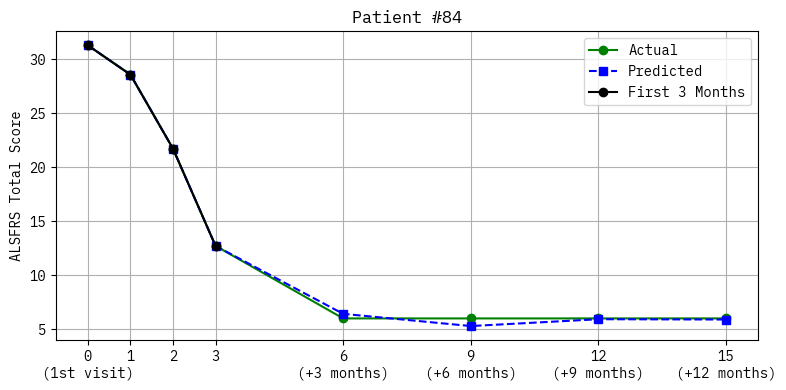

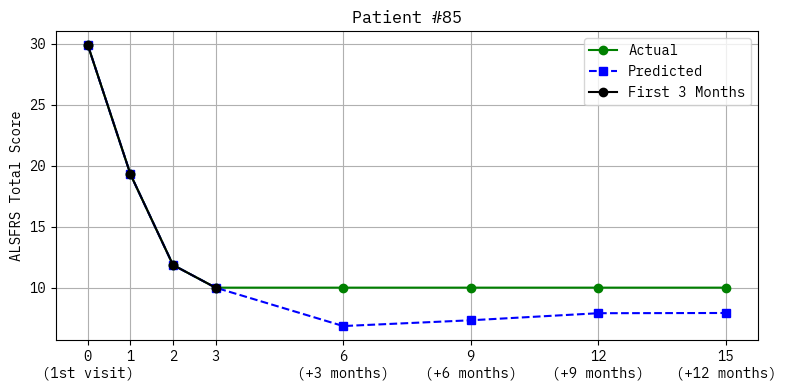

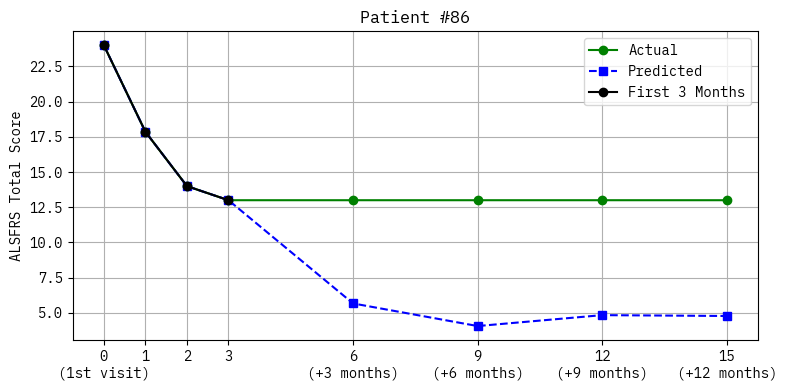

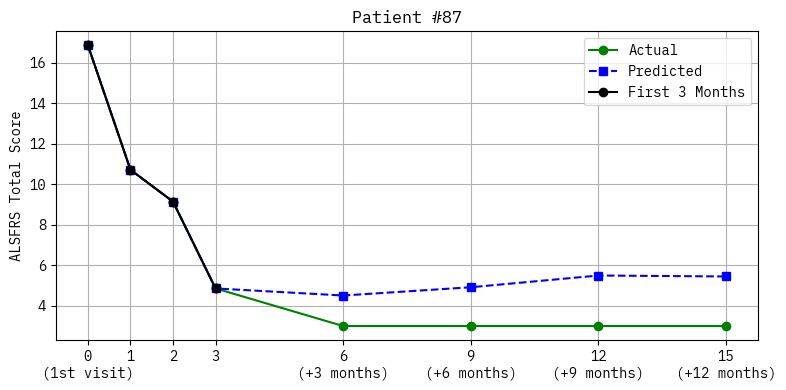

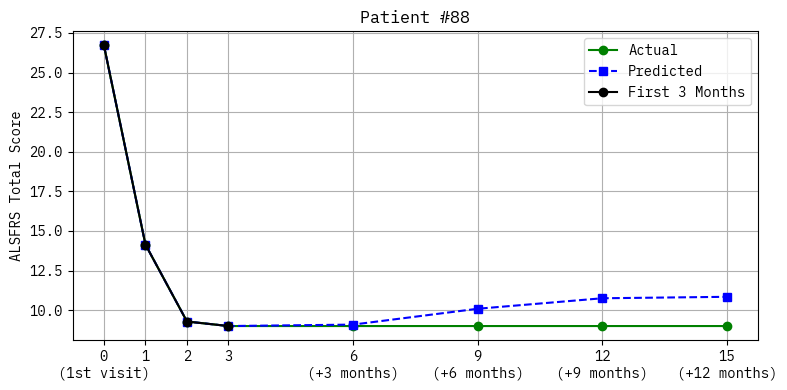

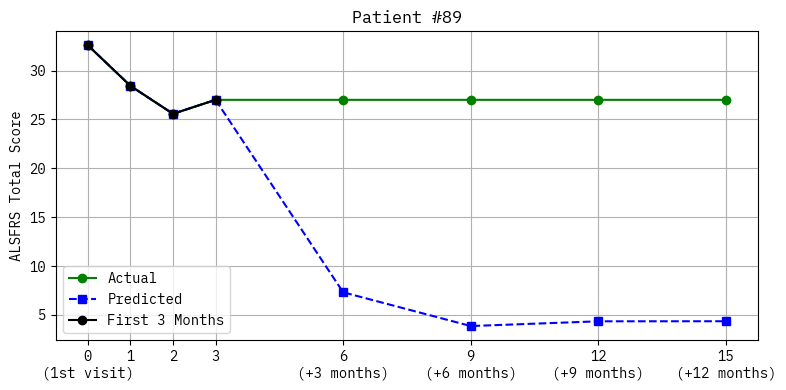

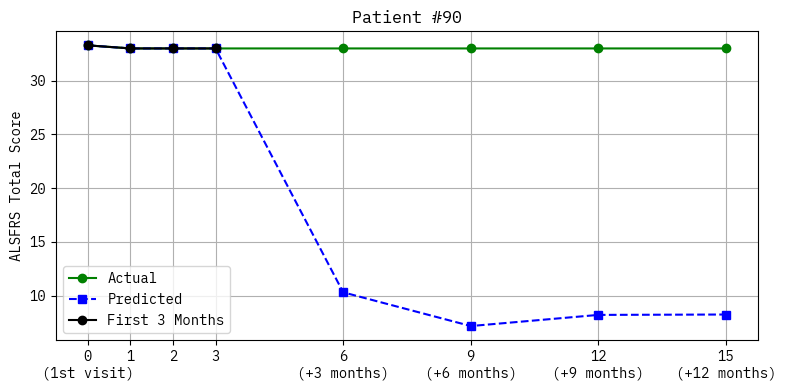

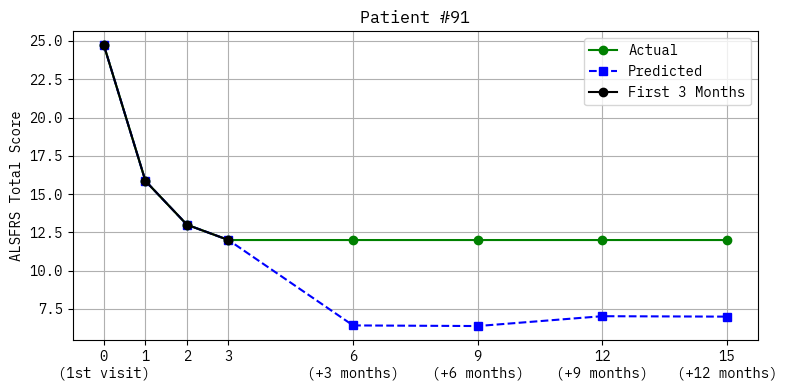

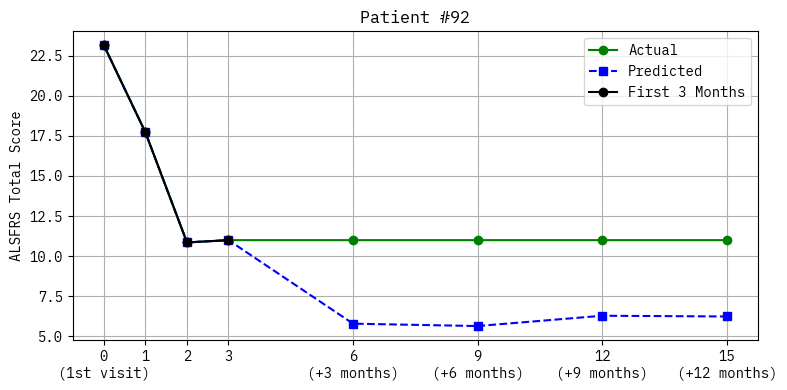

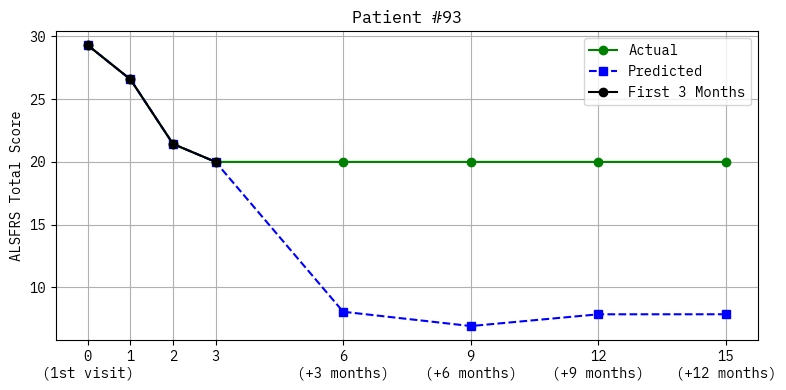

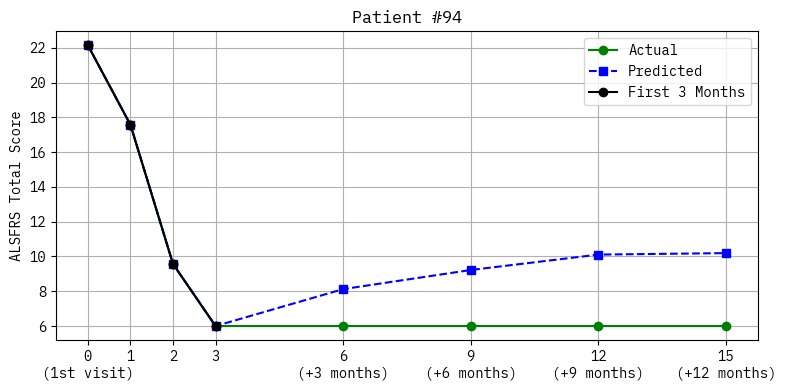

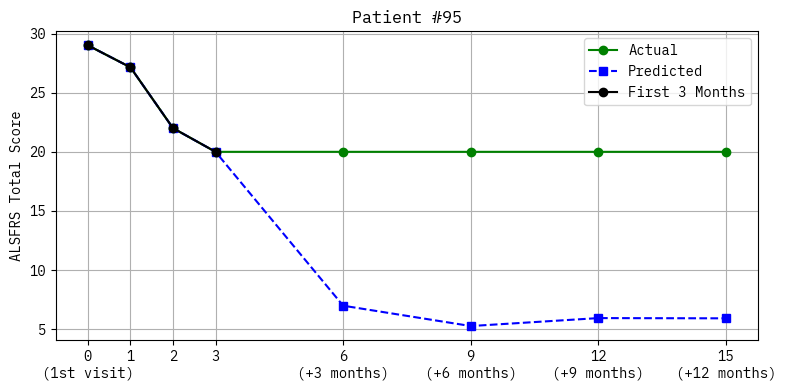

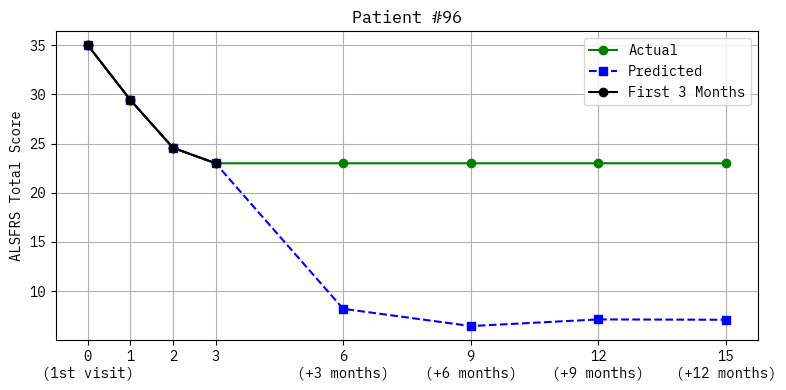

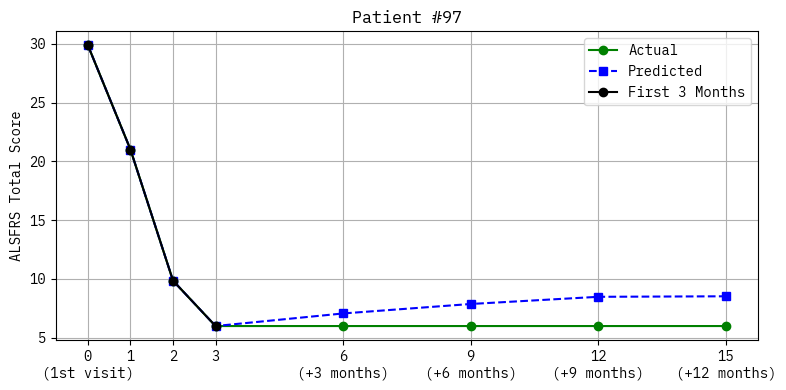

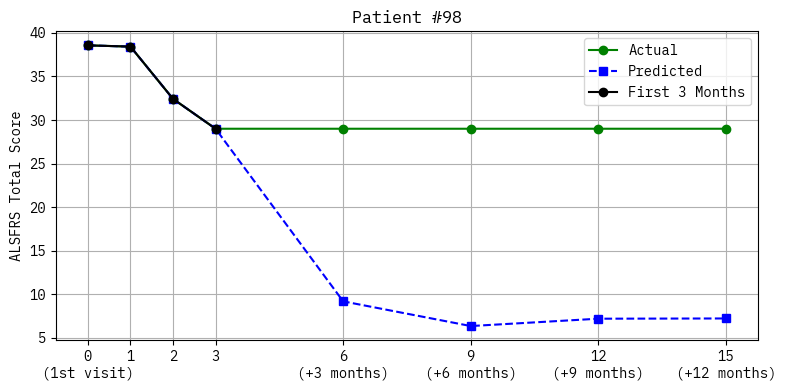

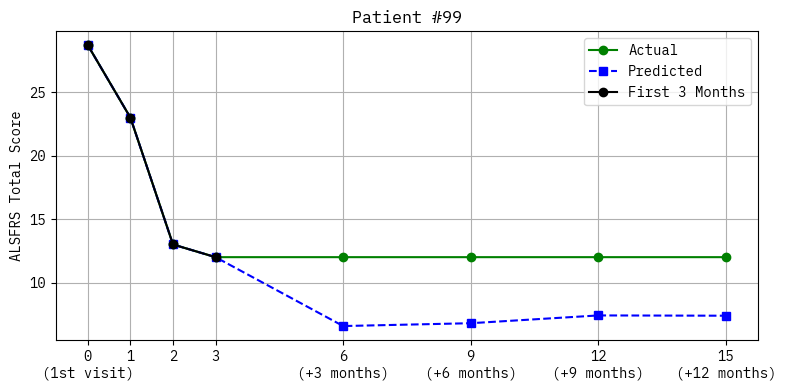

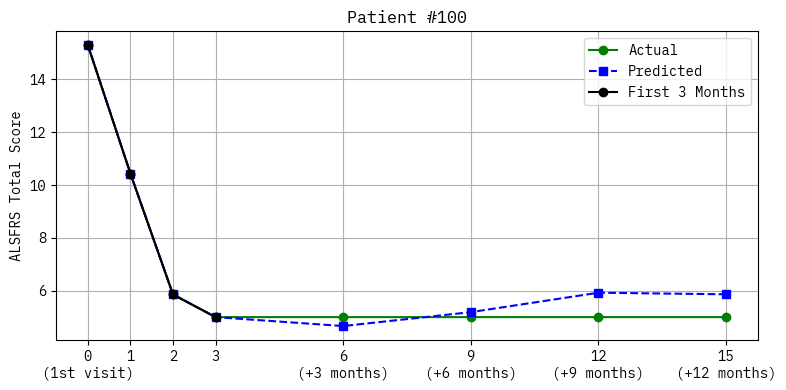

In [146]:
import tqdm

os.makedirs("results/predicted", exist_ok=True)
for pid in tqdm.tqdm(range(100), desc="[INFO] Forecasting Patient ALS Progression :"):
    try:
        plot_actual_vs_pred_for_patient(pid)
    except Exception:
        break